# Imports

In [2]:
import warnings
import pandas as pd
import sweetviz as sv
from sqlalchemy import create_engine

from sql.postgres_connection import (dbname, password, host, port, database)
from sql.comprasgov_modo_disputa_obras_sql import (full_sql_query)

# Suppress FutureWarning from sweetviz
warnings.simplefilter(action='ignore', category=FutureWarning)

c:\Users\Hugo\miniconda3\envs\comprasgov\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dispute Mode vs. Price

## Siasgnet

In [3]:
# Database Connection Function
def read_data_from_postgres(query):
    try:
        engine = create_engine(f'postgresql://{dbname}:{password}@{host}:{port}/{database}')
        df = pd.read_sql_query(query, engine)
        
    except Exception as e:
        print("An error occurred:", e)
        
    return df

# Test Connection
df_siasgnet = read_data_from_postgres(full_sql_query)

df_siasgnet_original = df_siasgnet.copy()
df_siasgnet

,link,codcompra,coditem,codigolicitacao,codigoitemlicitacao,numerouasgorigem,numerouasgresponsavel,numerolicitacao,anolicitacao,mododisputa,...,numeroitem,quantidade,quantidadeconsistente,codigosituacaoitemlicitacao,subcontratacao,codigotipoitem,utilizamargempreferencia,valorestimado,datahoraregistrolicitacao,datahoraregistroitem
0,https://compras.dados.gov.br/licitacoes/doc/rd...,17908599000752023,1790859900075202300001,9268,13106,179085,179085,00075,2023,Aberto,...,1,1,T,1,T,2,F,2.075558e+08,2023-09-26 17:21:12.562577,2021-11-17 13:08:34.446373
1,https://compras.dados.gov.br/licitacoes/doc/rd...,39301899001382023,3930189900138202300001,8772,12638,393018,393018,00138,2023,Aberto,...,1,1,T,1,T,2,F,3.342747e+06,2023-03-29 14:23:28.491598,2021-10-20 10:30:11.566951
2,https://compras.dados.gov.br/licitacoes/doc/rd...,92589499000112023,9258949900011202300001,9279,11995,925894,925894,00011,2023,Fechado,...,1,1,T,1,F,2,F,1.155054e+06,2023-09-29 08:59:10.238827,2021-08-05 17:44:49.918588
3,https://compras.dados.gov.br/licitacoes/doc/rd...,19500599000332023,1950059900033202300009,9276,11993,195005,195005,00033,2023,Aberto,...,9,1,T,1,T,2,F,2.333230e+05,2023-09-28 18:05:13.549244,2021-08-05 11:49:51.857516
4,https://compras.dados.gov.br/licitacoes/doc/rd...,19500599000332023,1950059900033202300008,9276,11992,195005,195005,00033,2023,Aberto,...,8,1,T,1,T,2,F,2.333230e+05,2023-09-28 18:05:13.549244,2021-08-05 11:46:26.595748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4345,https://compras.dados.gov.br/licitacoes/doc/rd...,39301399001722012,3930139900172201200001,10,10,393013,393013,00172,2012,Fechado/Aberto,...,1,1,T,1,F,2,F,1.705994e+08,2014-11-01 10:26:38.600225,2014-11-01 10:26:38.445144
4346,https://compras.dados.gov.br/licitacoes/doc/rd...,27507599000012012,2750759900001201200001,8,8,275075,275075,00001,2012,Fechado,...,1,1,T,1,F,2,F,8.512767e+07,2014-11-01 10:26:38.600225,2014-11-01 10:26:38.445144
4347,https://compras.dados.gov.br/licitacoes/doc/rd...,39301599005072012,3930159900507201200001,6,6,393015,393015,00507,2012,Fechado/Aberto,...,1,25,T,1,F,2,F,1.000000e-02,2014-11-01 10:26:38.600225,2014-11-01 10:26:38.445144
4348,https://compras.dados.gov.br/licitacoes/doc/rd...,39301399001822012,3930139900182201200001,5,5,393013,393013,00182,2012,Fechado/Aberto,...,1,1,T,1,F,2,F,1.560000e+08,2014-11-01 10:26:38.600225,2014-11-01 10:26:38.445144


In [4]:
df_siasgnet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4350 entries, 0 to 4349
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   link                         4350 non-null   object        
 1   codcompra                    4350 non-null   object        
 2   coditem                      4350 non-null   object        
 3   codigolicitacao              4350 non-null   int64         
 4   codigoitemlicitacao          4350 non-null   int64         
 5   numerouasgorigem             4350 non-null   int64         
 6   numerouasgresponsavel        4350 non-null   int64         
 7   numerolicitacao              4350 non-null   object        
 8   anolicitacao                 4350 non-null   object        
 9   mododisputa                  4350 non-null   object        
 10  criteriojulgamento           4350 non-null   object        
 11  codigomododisputa            4350 non-null 

### Dispute mode Exploration

In [5]:
# Make a copy of the original df_siasgnet DataFrame
df_siasgnet = df_siasgnet_original.copy()

# Show the distinct values of mododisputa on df_siasgnet
print(df_siasgnet['mododisputa'].unique())

# Create a new column disputaaberto that indicates whether the mododisputa is open or not
df_siasgnet['disputaaberto'] = df_siasgnet['mododisputa'].apply(
    lambda x: 'Aberto' if x in ['Aberto','Fechado/Aberto','Aberto/Fechado'] else 'Fechado')

# Count the number of True and False values in the disputaaberto column
df_siasgnet['disputaaberto'].value_counts()

['Aberto' 'Fechado' 'Fechado/Aberto' 'Aberto/Fechado']


disputaaberto
Aberto     3302
Fechado    1048
Name: count, dtype: int64

## Transformations and Filtering

In [6]:
# Convert the 'anolicitacao' column to integer type
df_siasgnet['anolicitacao'] = df_siasgnet['anolicitacao'].astype(int)

# Filter the DataFrame to only include rows with 'anolicitacao' between 2013 and 2022
df_siasgnet = df_siasgnet[(df_siasgnet['anolicitacao'] >= 2013) & (df_siasgnet['anolicitacao'] <= 2022)]

# Compute summary statistics for the DataFrame
df_siasgnet.describe()

,codigolicitacao,codigoitemlicitacao,numerouasgorigem,numerouasgresponsavel,anolicitacao,codigomododisputa,codigocriteriojulgamento,numeroitem,quantidade,codigosituacaoitemlicitacao,codigotipoitem,valorestimado,datahoraregistrolicitacao,datahoraregistroitem
count,3472.000000,3472.000000,3472.000000,3472.000000,3472.000000,3472.000000,3472.000000,3472.000000,3472.000000,3472.000000,3472.000000,3.472000e+03,3472,3472
mean,4201.737615,5283.538594,404610.618952,404610.618952,2018.434332,1.598502,1.536578,3.017569,35.037730,1.000288,1.969758,1.384072e+07,2019-03-04 00:12:43.643511296,2017-10-21 20:11:22.493662208
min,67.000000,88.000000,80003.000000,80003.000000,2013.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e-02,2014-11-01 10:26:38.600225,2014-11-01 10:26:38.445144
25%,1823.250000,2033.000000,155013.000000,155013.000000,2016.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.478671e+05,2016-08-30 03:05:11.916312576,2015-01-13 03:51:01.094825984
50%,4184.500000,5212.500000,195006.000000,195006.000000,2019.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.181961e+06,2019-10-15 21:58:59.262779136,2018-02-26 14:32:13.023356160
75%,6342.750000,8033.250000,910811.000000,910811.000000,2021.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,4.722003e+06,2021-08-11 21:33:55.369738240,2019-10-30 17:39:34.380196352
max,8932.000000,11249.000000,989581.000000,989581.000000,2022.000000,4.000000,4.000000,118.000000,13663.000000,2.000000,2.000000,1.242444e+09,2023-06-20 11:32:58.523845,2021-05-06 10:36:30.447191
std,2559.557423,3301.481452,328160.047937,328160.047937,2.920883,0.985681,0.731903,10.443327,440.846853,0.016971,0.171277,6.617569e+07,NaN,NaN


## SERPRO's Data Extraction

In [7]:
# Read the data from the '2023-09-29-extracao-rdc.ods' file using pandas read_excel() function
df_serpro = pd.read_excel('data/2023-09-29-extracao-rdc.ods', engine='odf')

# Make a copy of the original df_serpro DataFrame
df_serpro_original = df_serpro.copy()

# Show the first few rows of the DataFrame using the head() method
df_serpro.head()

,Ano da compra,Tipo da compra,Número da Uasg,Número / Ano da Compra,Número do Item,Grupo do Item,Objeto da Compra,UF da Uasg,Regime de Execução,Critério de Julgamento,...,Quantidade do Item,Orçamento Estimado do Item,Tipo de Benefício do Item,Valor Adjudicado,Melhor Lance,Valor Final Negociado,Quantidade de Participantes do Item,Situação da Compra,Situação do Item,Identificação do Fornecedor Vencedor (adjudicado)
0,2013,RDC,153028,1/2013,1,NaN,"Objeto: Contratação de empresa de engenharia, ...",MG,Empreitada por Preço Global,Menor Preço,...,1,1983590.35,Sem benefícios,1980000.0,2060000.00,1980000.0,4,Homologada,Homologado,11301559000178 - T & T EDIFICACOES LTDA - EPP(...
1,2013,RDC,153028,2/2013,1,NaN,"Objeto: Contratação de empresa de engenharia, ...",MG,Empreitada por Preço Global,Menor Preço,...,1,1774561.72,Sem benefícios,1770000.0,1869000.00,1770000.0,5,Homologada,Homologado,09321831000130 - CONSTRUTORA SANTIAGO LTDA - E...
2,2013,RDC,153028,3/2013,1,NaN,"Objeto: Contratação de empresa de engenharia, ...",MG,Empreitada por Preço Global,Menor Preço,...,1,1773413.65,Sem benefícios,1710000.0,1848999.99,1710000.0,2,Homologada,Homologado,09236291000196 - FLAVIO DONIZETE FERREIRA & CI...
3,2013,RDC,153028,4/2013,1,NaN,"Objeto: Contratação de empresa de engenharia, ...",MG,Empreitada por Preço Global,Menor Preço,...,1,4765528.54,Sem benefícios,4745000.0,6050000.00,4745000.0,5,Homologada,Homologado,19318799000197 - VECON VOLPINI ENGENHARIA E CO...
4,2013,RDC,153030,1/2013,1,NaN,Objeto: Contratação de empresa do ramo de cons...,MG,Empreitada por Preço Global,Menor Preço,...,1,5491716.59,Sem benefícios,5060000.0,5060000.00,NaN,5,Homologada,Homologado,11301559000178 - T & T EDIFICACOES LTDA - EPP(...


In [8]:
# Print information about the df_serpro DataFrame using the info() method
df_serpro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7382 entries, 0 to 7381
Data columns (total 27 columns):
 #   Column                                             Non-Null Count  Dtype         
---  ------                                             --------------  -----         
 0   Ano da compra                                      7382 non-null   int64         
 1   Tipo da compra                                     7382 non-null   object        
 2   Número da Uasg                                     7382 non-null   int64         
 3   Número / Ano da Compra                             7382 non-null   object        
 4   Número do Item                                     7382 non-null   int64         
 5   Grupo do Item                                      1181 non-null   object        
 6   Objeto da Compra                                   7382 non-null   object        
 7   UF da Uasg                                         7382 non-null   object        
 8   Regime de Execução

### Transformations

In [9]:
# Convert the 'Número da Uasg' and 'Número / Ano da Compra' columns to string type
string_cols = [
    'Número da Uasg', 
    'Número / Ano da Compra',
    ]
df_serpro[string_cols] = df_serpro[string_cols].astype(str)

# Pad the 'Número da Uasg' column with zeros to 6 digits and store the result in a new 'uasg' column
df_serpro['uasg'] = df_serpro['Número da Uasg'].str.zfill(6)

# Split the 'Número / Ano da Compra' column into 'compra' and 'ano' columns using the '/' character as a separator
df_serpro[['compra', 'ano']] = df_serpro['Número / Ano da Compra'].str.split('/', expand=True)

# Pad the 'compra' column with zeros to 5 digits and the 'ano' column with zeros to 4 digits
df_serpro['compra'] = df_serpro['compra'].str.zfill(5)
df_serpro['ano'] = df_serpro['ano'].str.zfill(4)

# Concatenate the 'uasg', 'compra', and 'ano' columns to create a new 'codcompra' column
df_serpro['codcompra'] = df_serpro['uasg'] + '99' + df_serpro['compra'] + df_serpro['ano']

# Show the 'codcompra' column
df_serpro['codcompra']

0       15302899000012013
1       15302899000022013
2       15302899000032013
3       15302899000042013
4       15303099000012013
              ...        
7377    98010899000012023
7378    98412399100012023
7379    98412399100022023
7380    98412399100032023
7381    98412399100042023
Name: codcompra, Length: 7382, dtype: object

### Filtering

In [10]:
# Clean rows where df_serpro['Orçamento Estimado do Item'] == 0.01
df_serpro = df_serpro[df_serpro['Orçamento Estimado do Item'] != 0.01]

# Clean rows where df_serpro['Identificação do Fornecedor Vencedor (adjudicado)'] == Sem vencedor
df_serpro = df_serpro[df_serpro['Identificação do Fornecedor Vencedor (adjudicado)'] != 'Sem vencedor']

# df_serpro['valorhomologado'] = df_serpro.apply(lambda x: x['Melhor Lance'] if pd.isnull(x['Valor Final Negociado']) else x['Valor Final Negociado'], axis=1)

## Join DataFrames (df_serpro, df_siasgnet)

In [11]:
# Concatenate df_serpro with df_siasgnet.mododisputa using codcompra as key
df_serpro_siasgnet = pd.merge(
    df_serpro, df_siasgnet[[
        'codcompra', 
        'mododisputa', 
        'disputaaberto', 
        'codigoitemcatalogo', 
        'link']], 
    how='inner', 
    on='codcompra'
    )

# Compute the percentual_valor_final column as the ratio of valorhomologado to Orçamento Estimado do Item
df_serpro_siasgnet['percentual_valor_final'] = df_serpro_siasgnet['Valor Adjudicado'] / df_serpro_siasgnet['Orçamento Estimado do Item'] * 100
    # df_serpro_siasgnet['percentual_valor_final'] = ((df_serpro_siasgnet['Valor Adjudicado'] / df_serpro_siasgnet['Orçamento Estimado do Item']) - 1) * 100

# Eliminate outliers
df_serpro_siasgnet = df_serpro_siasgnet[(df_serpro_siasgnet['percentual_valor_final'] <= 200) & (df_serpro_siasgnet['percentual_valor_final'] >= 20)]

# Print the shape of the resulting DataFrame and show the DataFrame
print(df_serpro_siasgnet.shape)
df_serpro_siasgnet

(2759, 36)


,Ano da compra,Tipo da compra,Número da Uasg,Número / Ano da Compra,Número do Item,Grupo do Item,Objeto da Compra,UF da Uasg,Regime de Execução,Critério de Julgamento,...,Identificação do Fornecedor Vencedor (adjudicado),uasg,compra,ano,codcompra,mododisputa,disputaaberto,codigoitemcatalogo,link,percentual_valor_final
0,2013,RDC,153030,13/2013,1,NaN,Objeto: Contratação de empresa de engenharia c...,MG,Empreitada por Preço Global,Menor Preço,...,65280604000184 - 3E INDUSTRIA E COMERCIO LTDA ...,153030,00013,2013,15303099000132013,Aberto,Aberto,4545,https://compras.dados.gov.br/licitacoes/doc/rd...,99.710288
1,2013,RDC,153033,4/2013,1,NaN,Objeto: Contratação de pessoa jurídica especia...,RN,Empreitada por Preço Unitário,Menor Preço,...,05806903000188 - POLY CONSTRUCOES & EMPREENDIM...,153033,00004,2013,15303399000042013,Fechado/Aberto,Aberto,1937,https://compras.dados.gov.br/licitacoes/doc/rd...,88.997969
2,2013,RDC,153033,4/2013,1,NaN,Objeto: Contratação de pessoa jurídica especia...,RN,Empreitada por Preço Unitário,Menor Preço,...,05806903000188 - POLY CONSTRUCOES & EMPREENDIM...,153033,00004,2013,15303399000042013,Fechado/Aberto,Aberto,1937,https://compras.dados.gov.br/licitacoes/doc/rd...,88.997969
3,2013,RDC,153033,4/2013,1,NaN,Objeto: Contratação de pessoa jurídica especia...,RN,Empreitada por Preço Unitário,Menor Preço,...,05806903000188 - POLY CONSTRUCOES & EMPREENDIM...,153033,00004,2013,15303399000042013,Fechado/Aberto,Aberto,1937,https://compras.dados.gov.br/licitacoes/doc/rd...,88.997969
4,2013,RDC,153033,4/2013,1,NaN,Objeto: Contratação de pessoa jurídica especia...,RN,Empreitada por Preço Unitário,Menor Preço,...,05806903000188 - POLY CONSTRUCOES & EMPREENDIM...,153033,00004,2013,15303399000042013,Fechado/Aberto,Aberto,1937,https://compras.dados.gov.br/licitacoes/doc/rd...,88.997969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2772,2022,RDC,984123,10001/2022,2,NaN,Objeto: Serviços e Obras de Urbanização das ru...,MG,Empreitada por Preço Unitário,Menor Preço,...,71474936000100 - CARVALHO QUEIROZ ENGENHARIA L...,984123,10001,2022,98412399100012022,Fechado,Fechado,5622,https://compras.dados.gov.br/licitacoes/doc/rd...,86.846507
2773,2022,RDC,984123,10003/2022,1,NaN,Objeto: Serviços e Obras de Estabilização de E...,MG,Empreitada por Preço Unitário,Menor Preço,...,04910686000109 - CONEST ENGENHARIA LTDA(Pessoa...,984123,10003,2022,98412399100032022,Fechado,Fechado,5622,https://compras.dados.gov.br/licitacoes/doc/rd...,84.821926
2774,2022,RDC,984123,10004/2022,1,NaN,Objeto: Complementação das obras de infraestru...,MG,Empreitada por Preço Unitário,Menor Preço,...,04910686000109 - CONEST ENGENHARIA LTDA(Pessoa...,984123,10004,2022,98412399100042022,Fechado,Fechado,22896,https://compras.dados.gov.br/licitacoes/doc/rd...,88.749445
2775,2022,RDC,988815,7/2022,1,NaN,Objeto: Serviços de implantação de elementos d...,RS,Empreitada por Preço Global,Maior Desconto,...,01814959000123 - CONSTRUCOST LTDA(Pessoa Juríd...,988815,00007,2022,98881599000072022,Aberto,Aberto,1619,https://compras.dados.gov.br/licitacoes/doc/rd...,94.000000


### Rename Columns

In [12]:
# Make all column names lower case and snake case
df_serpro_siasgnet.columns = df_serpro_siasgnet.columns \
    .str.lower() \
    .str.replace(' ', '_') \
    .str.replace('_/_', '_')
df_serpro_siasgnet.columns

Index(['ano_da_compra', 'tipo_da_compra', 'número_da_uasg',
       'número_ano_da_compra', 'número_do_item', 'grupo_do_item',
       'objeto_da_compra', 'uf_da_uasg', 'regime_de_execução',
       'critério_de_julgamento', 'data_hora_da_primeira_publicação',
       'data_hora_realização_do_certame_fim_proposta',
       'data_hora_de_homologação_da_compra',
       'data_hora_de_homologação_do_item', 'tipo_do_item', 'nome_do_item',
       'unidade_de_fornecimento_do_item', 'quantidade_do_item',
       'orçamento_estimado_do_item', 'tipo_de_benefício_do_item',
       'valor_adjudicado', 'melhor_lance', 'valor_final_negociado',
       'quantidade_de_participantes_do_item', 'situação_da_compra',
       'situação_do_item', 'identificação_do_fornecedor_vencedor_(adjudicado)',
       'uasg', 'compra', 'ano', 'codcompra', 'mododisputa', 'disputaaberto',
       'codigoitemcatalogo', 'link', 'percentual_valor_final'],
      dtype='object')

## Média do percentual dos valores homologados em relação aos  estimados por modo de disputa

mododisputa
Aberto            83.16 (1978)
Aberto/Fechado      87.39 (60)
Fechado             80.4 (503)
Fechado/Aberto     87.58 (218)
Name: percentual_valor_final, dtype: object

disputaaberto
Aberto     83.7 (2256)
Fechado     80.4 (503)
Name: percentual_valor_final, dtype: object
(2759, 36)


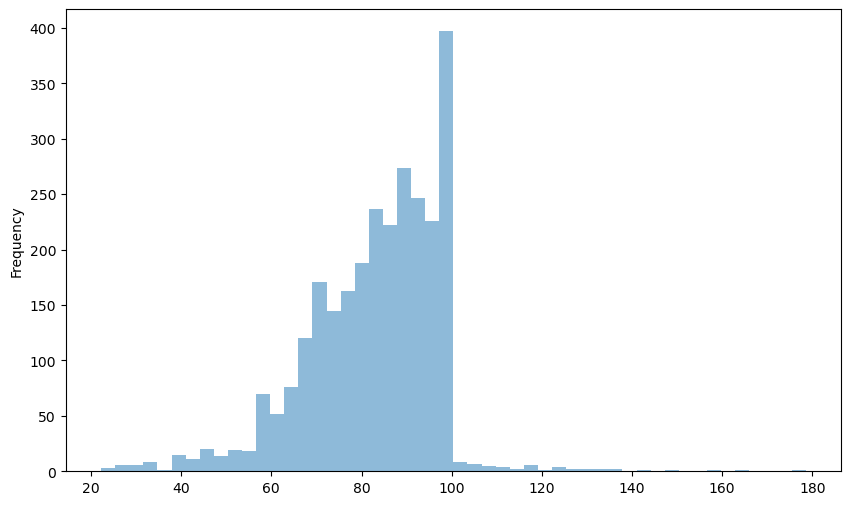

In [13]:
# Eliminate outliers from percentual_valor_final
df_plot = df_serpro_siasgnet.copy()

# Calculate the mean of percentual_valor_final by mododisputa rounded to 2 decimal places
# print(df_plot.groupby('mododisputa')['percentual_valor_final'].mean().round(2)
print((df_plot.groupby('mododisputa')['percentual_valor_final'].mean().round(2)).astype(str) + 
      ' (' + df_plot.groupby('mododisputa')['percentual_valor_final'].count().astype(str) + ')')
print('')
print((df_plot.groupby('disputaaberto')['percentual_valor_final'].mean().round(2)).astype(str) + 
      ' (' + df_plot.groupby('disputaaberto')['percentual_valor_final'].count().astype(str) + ')')

# Calculate and plot the distribution of percentual_valor_final
df_plot['percentual_valor_final'].plot.hist(bins=50, figsize=(10,6), alpha=0.5)
print(df_plot.shape)

In [14]:
# Replicate the print output to a dataframe
df_mododisputa_consolidado_valores = df_serpro_siasgnet.groupby('mododisputa')['percentual_valor_final'].agg(['mean', 'count']).round(2).reset_index().rename(columns={'mododisputa': 'Modo de Disputa', 'mean': 'Média', 'count': 'Quantidade'})
df_disputaaberto_consolidado_valores = df_serpro_siasgnet.groupby('disputaaberto')['percentual_valor_final'].agg(['mean', 'count']).round(2).reset_index().rename(columns={'disputaaberto': 'Modo de Disputa Agregado', 'mean': 'Média', 'count': 'Quantidade'})
print(df_mododisputa_consolidado_valores)
print('')
print(df_disputaaberto_consolidado_valores)

  Modo de Disputa  Média  Quantidade
0          Aberto  83.16        1978
1  Aberto/Fechado  87.39          60
2         Fechado  80.40         503
3  Fechado/Aberto  87.58         218

  Modo de Disputa Agregado  Média  Quantidade
0                   Aberto   83.7        2256
1                  Fechado   80.4         503


### SweetViz

Feature: percentual_valor_final (TARGET)     |▍         | [  5%]   00:00 -> (00:00 left)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



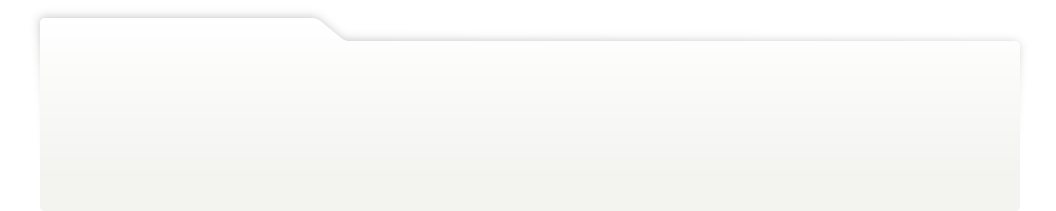
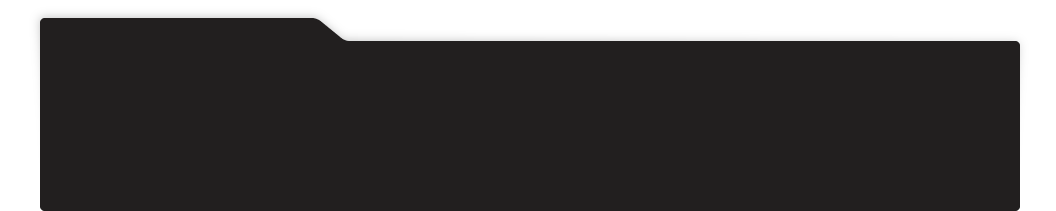
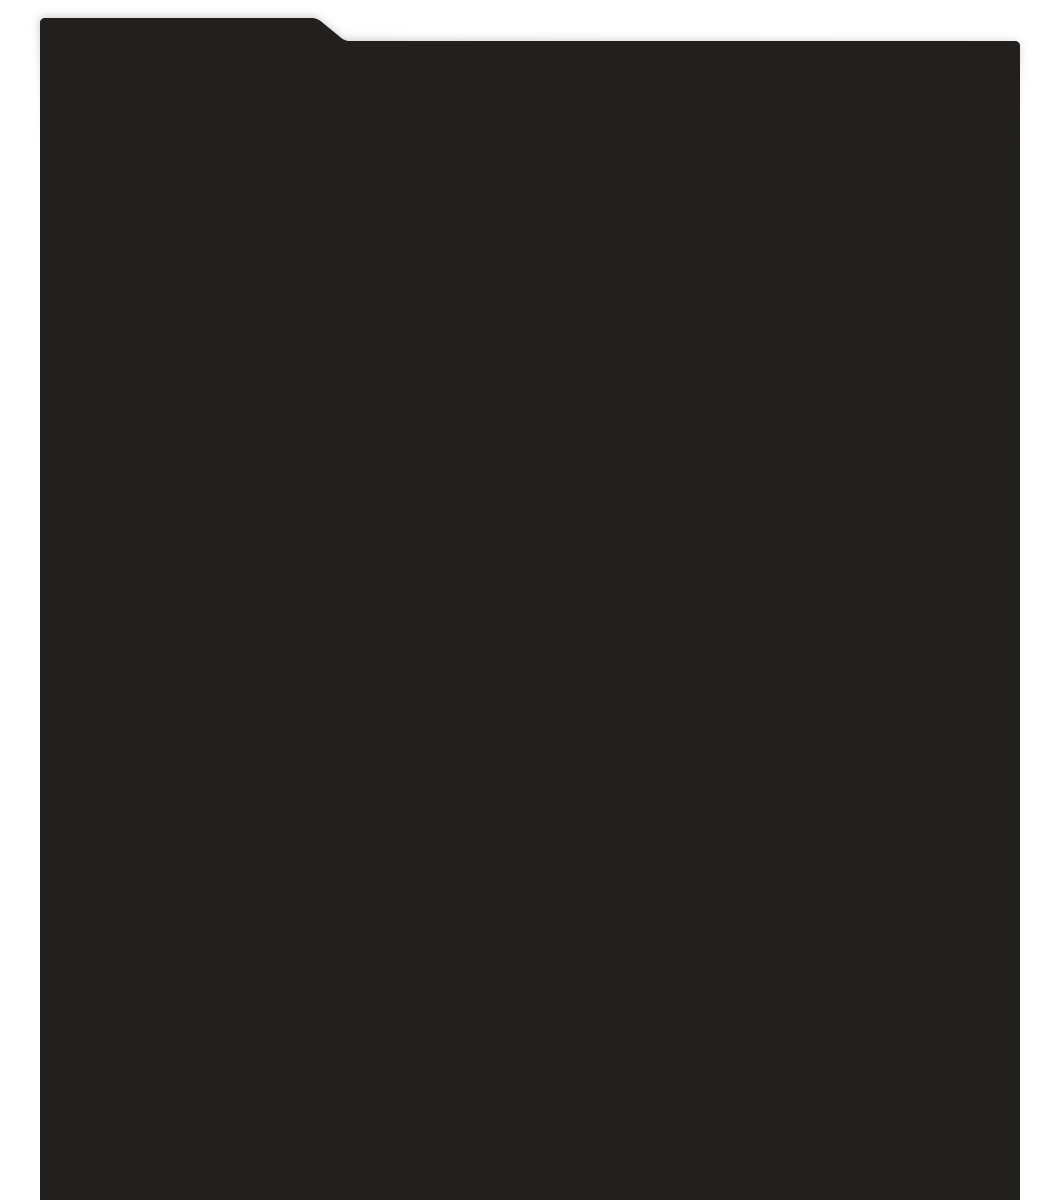
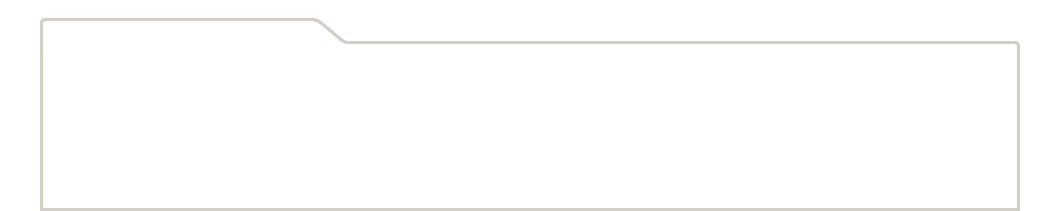
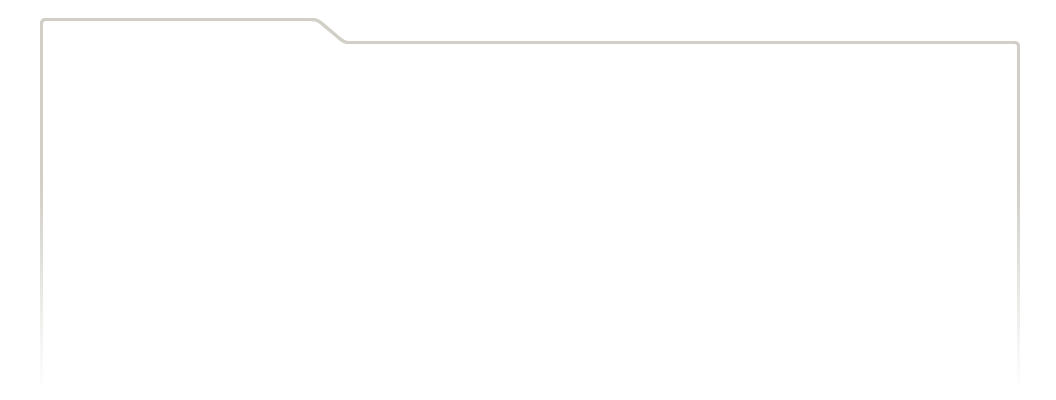
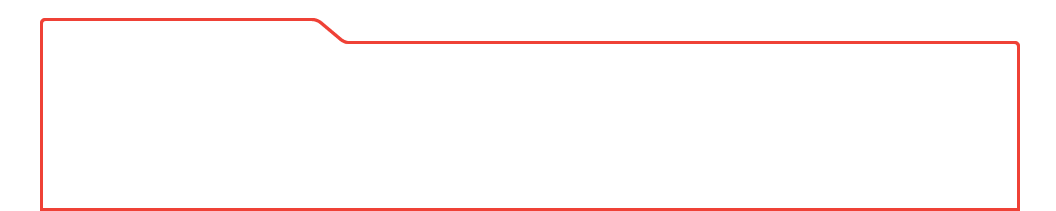
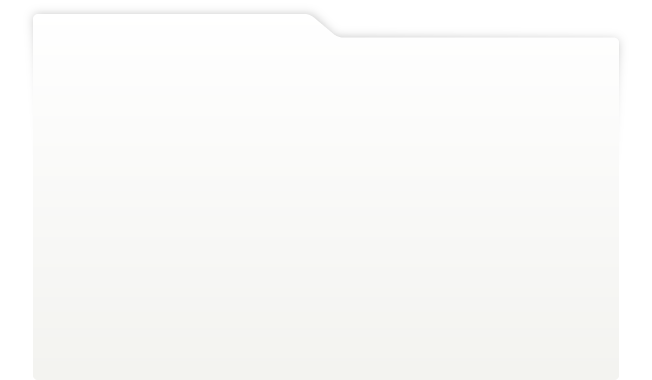
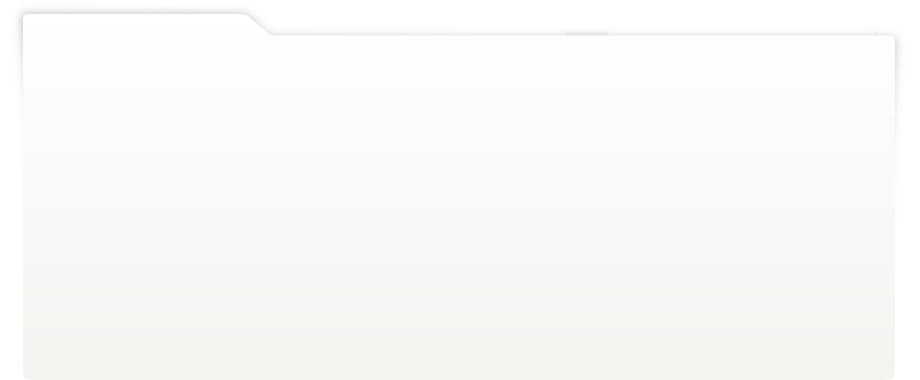
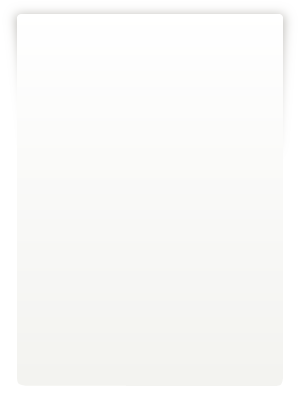
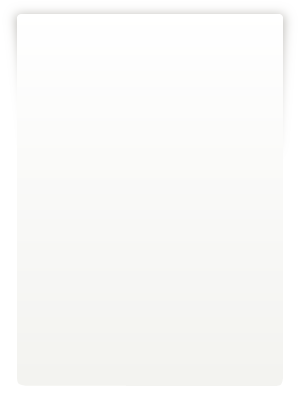
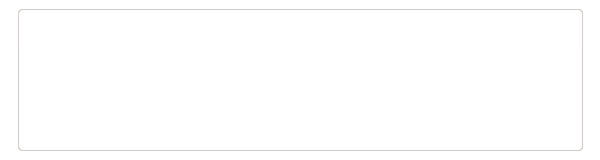
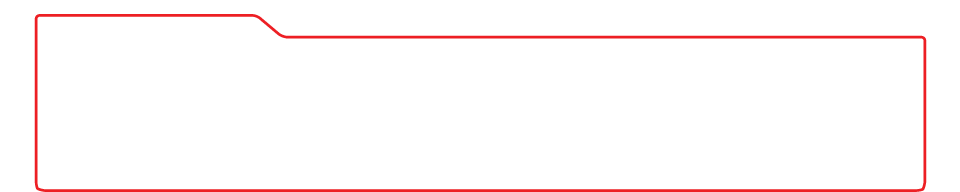
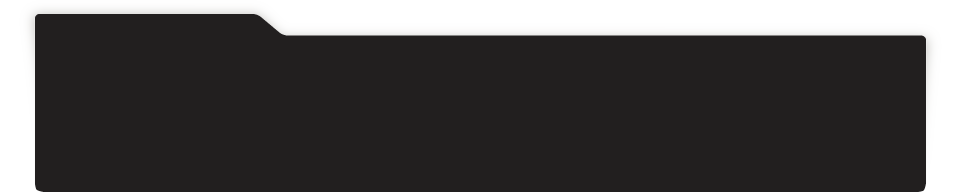
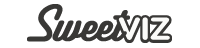
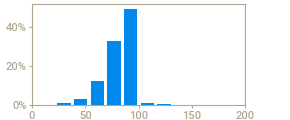
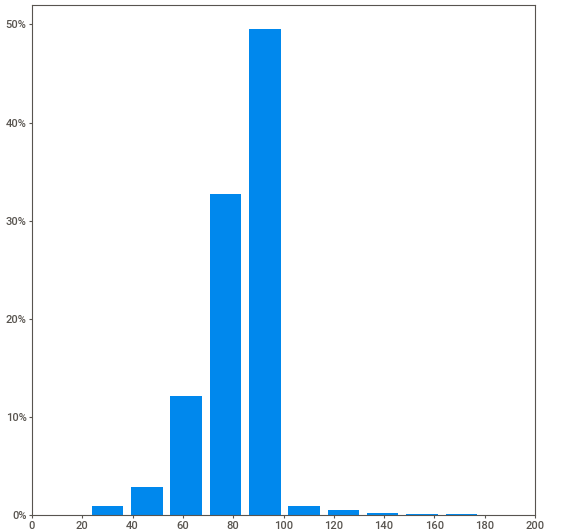
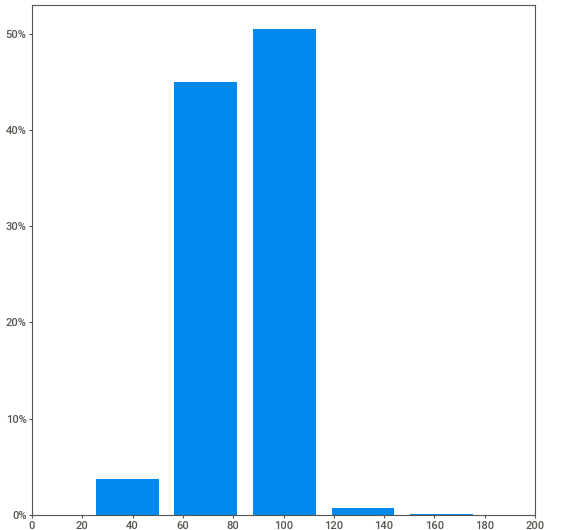
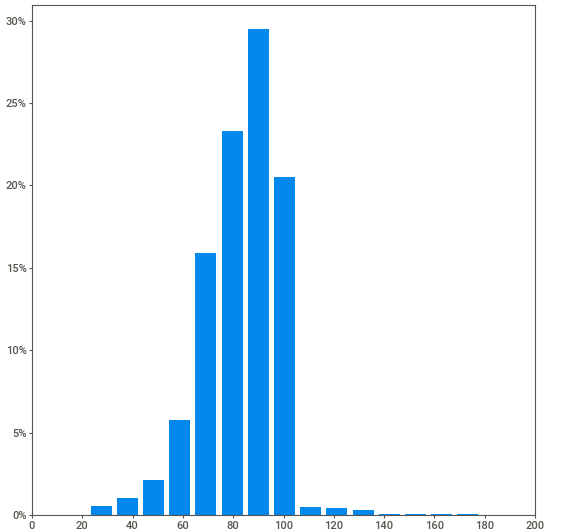
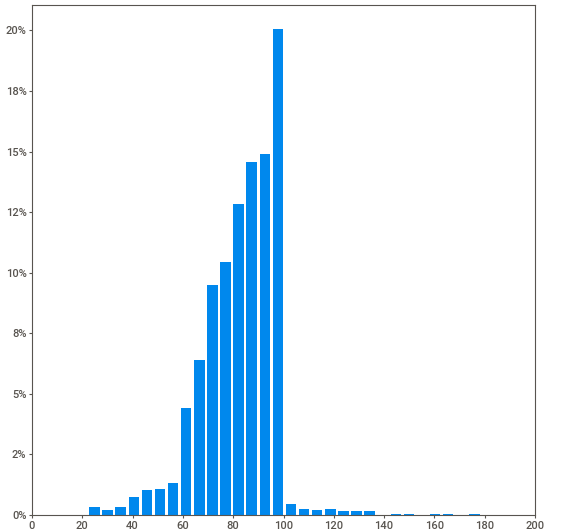
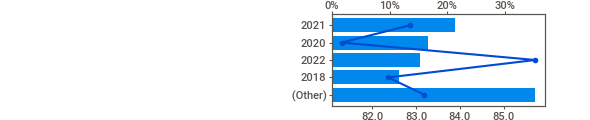
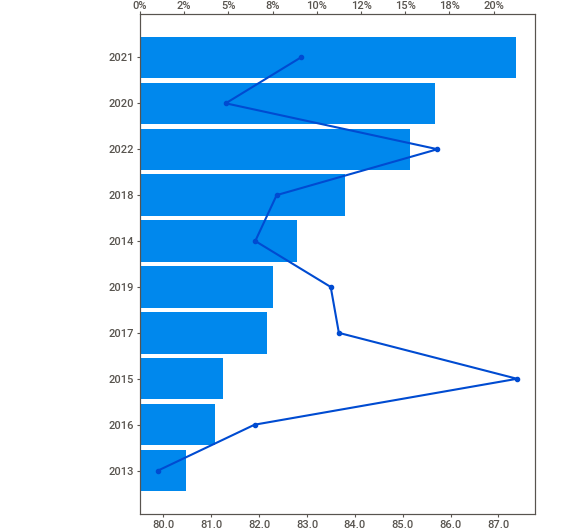
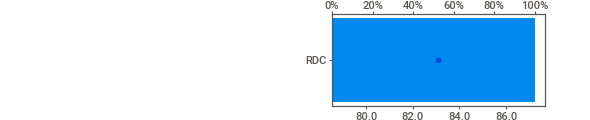
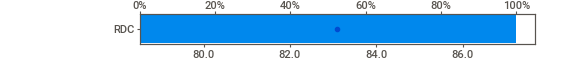
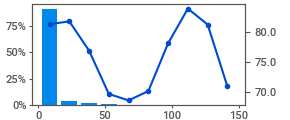
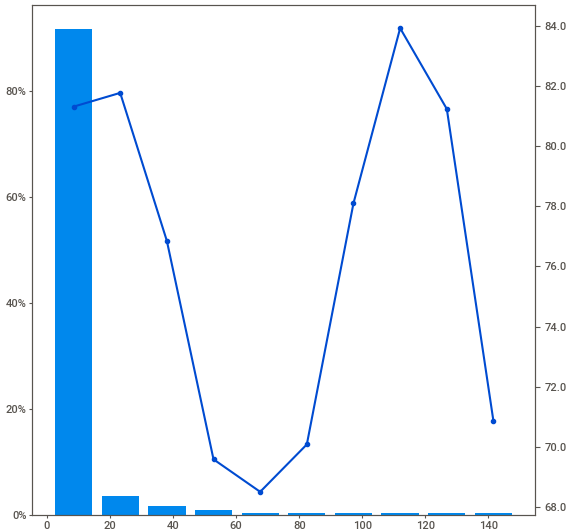
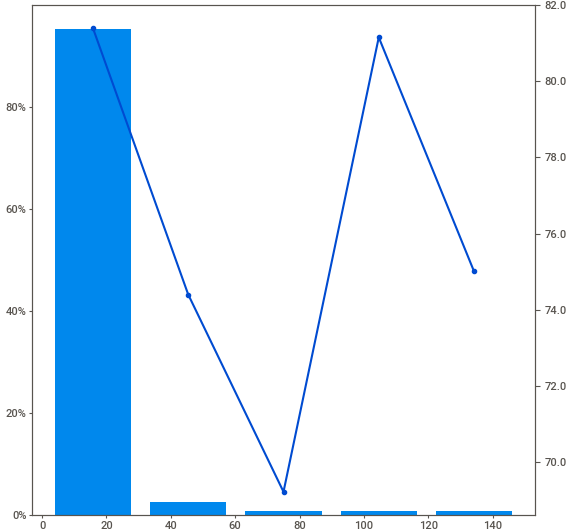
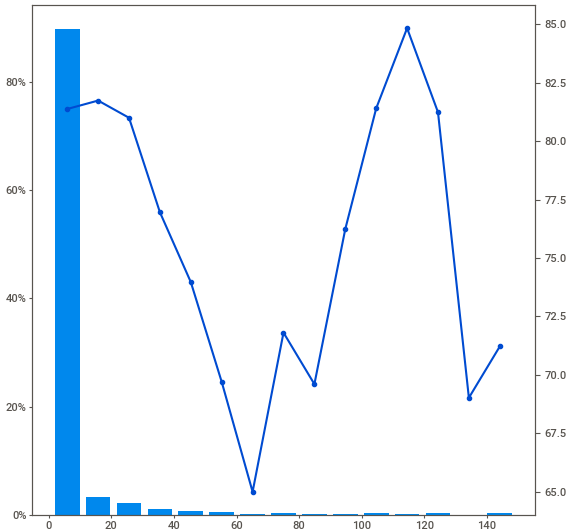
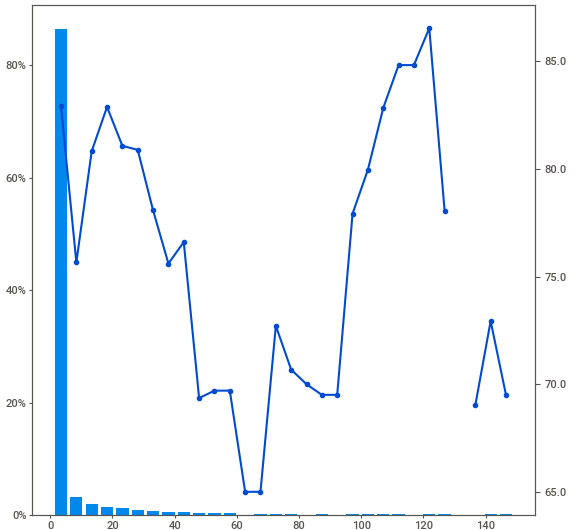
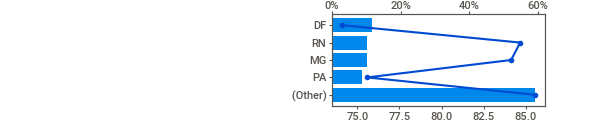
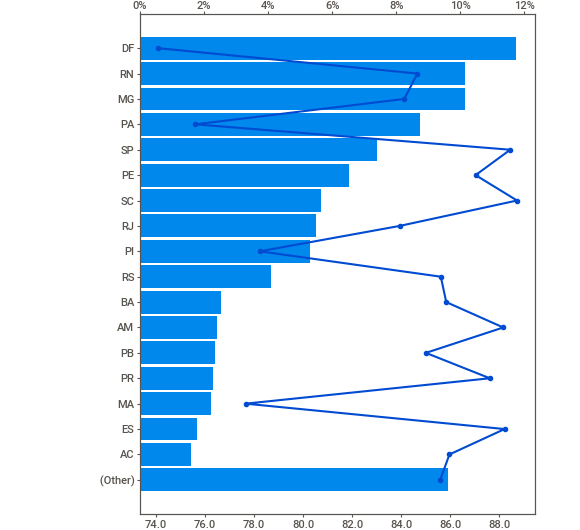
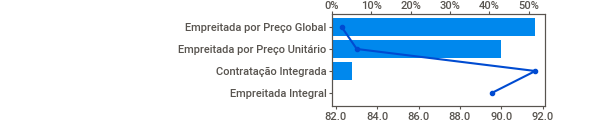
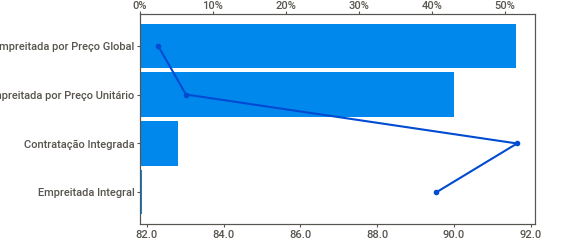
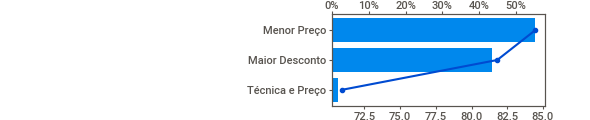
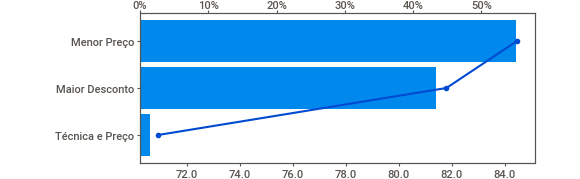
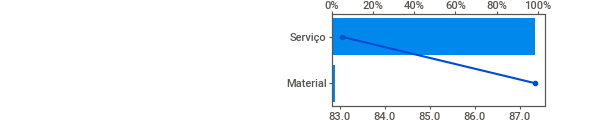
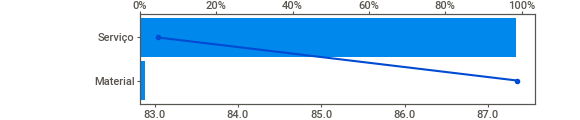
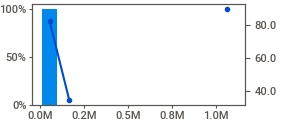
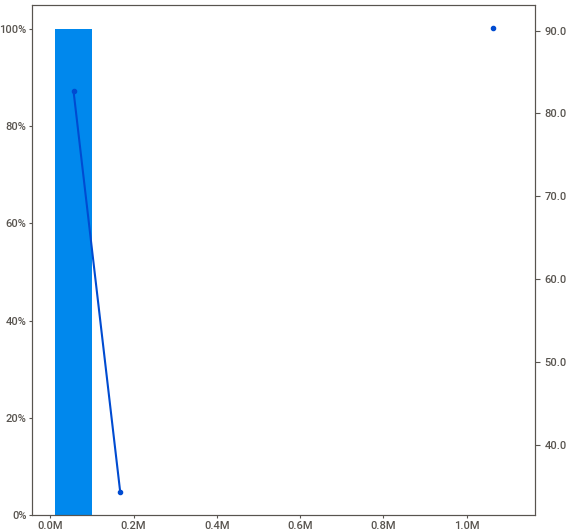
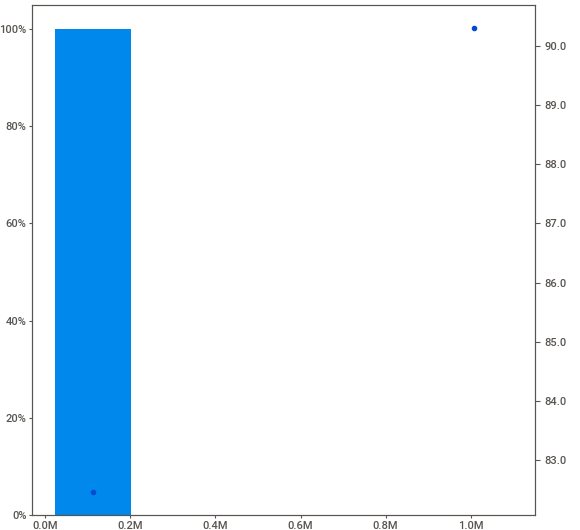
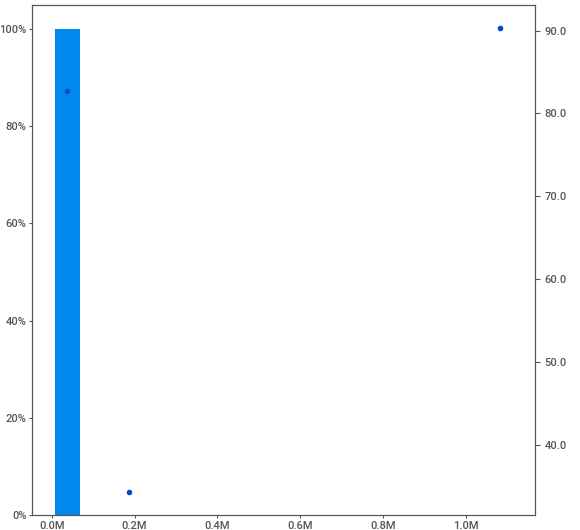
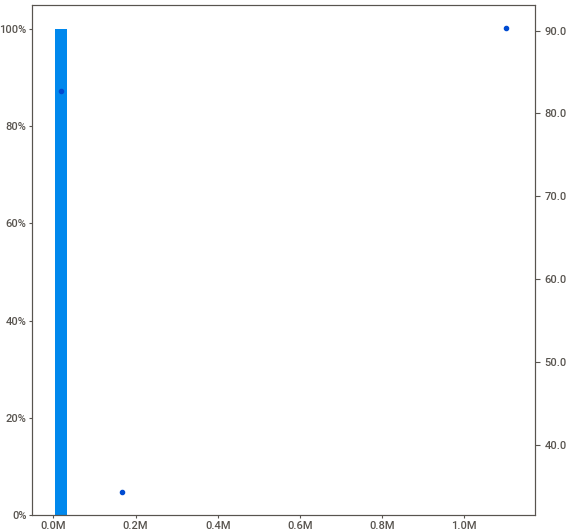
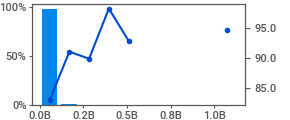
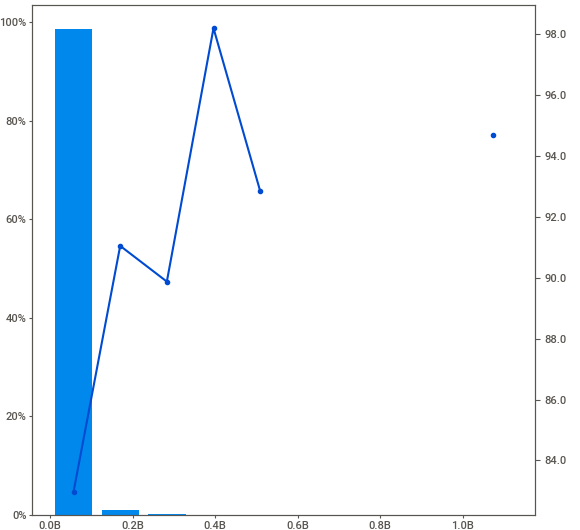
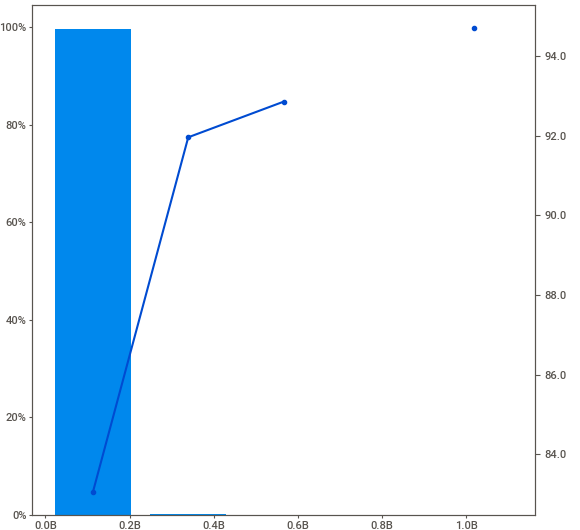
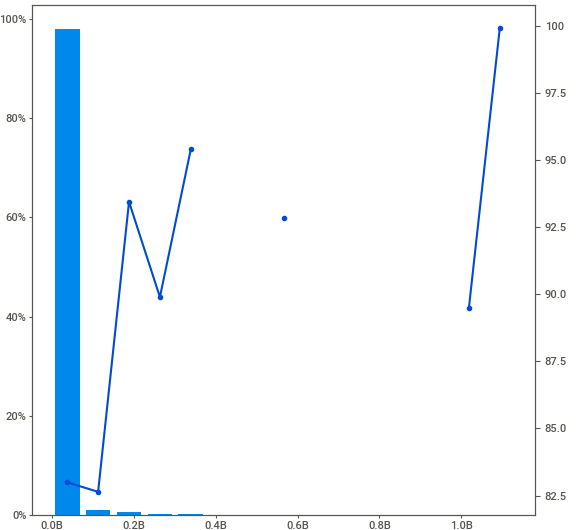
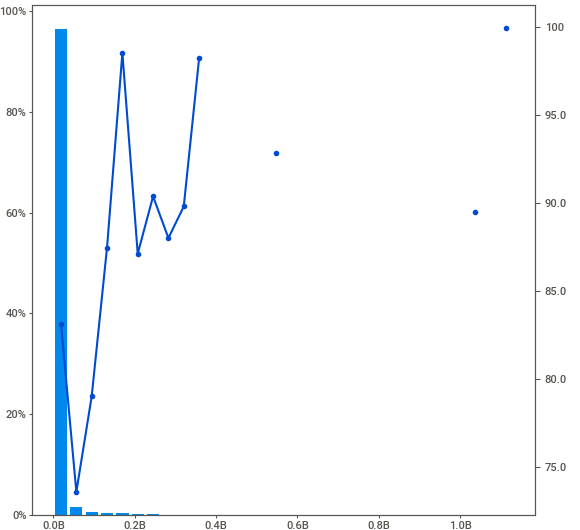
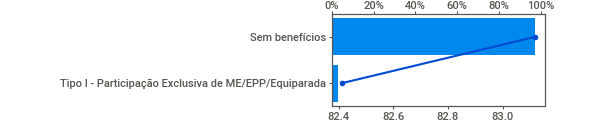
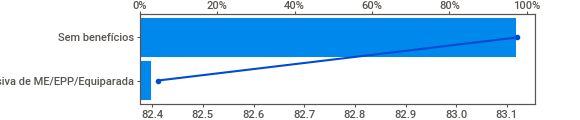
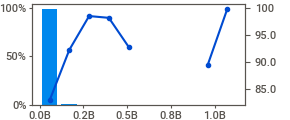
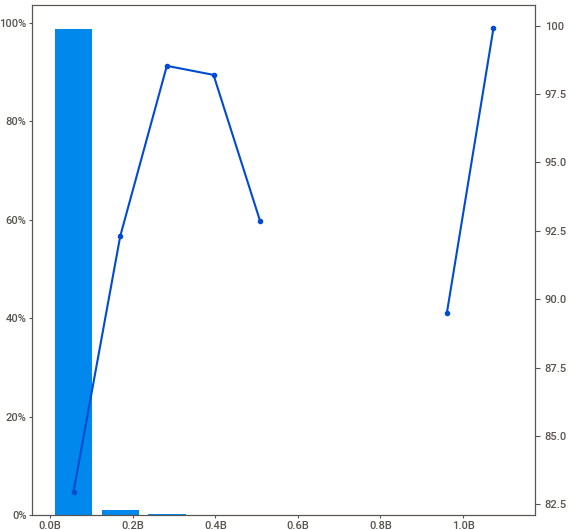
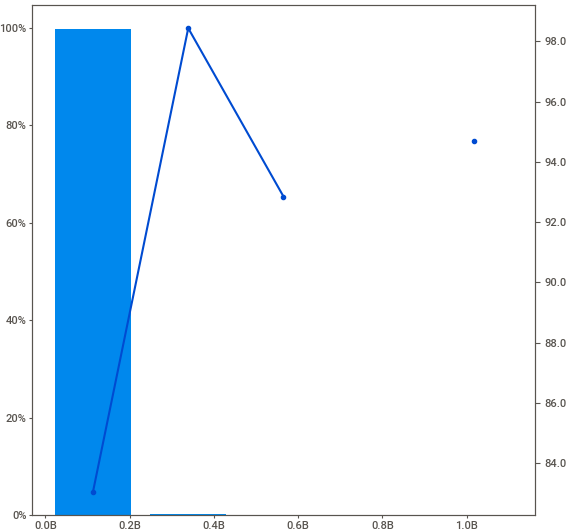
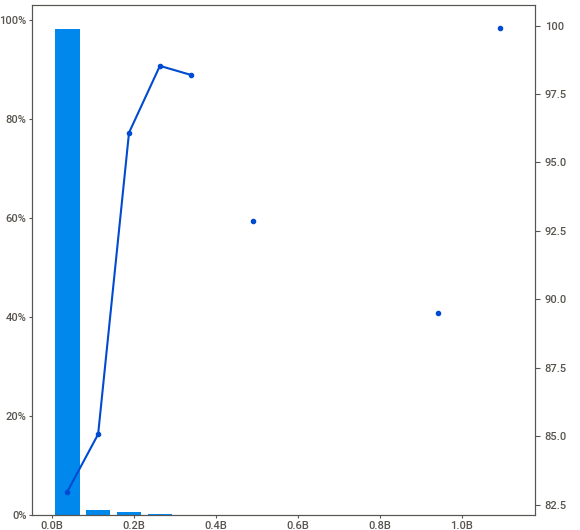
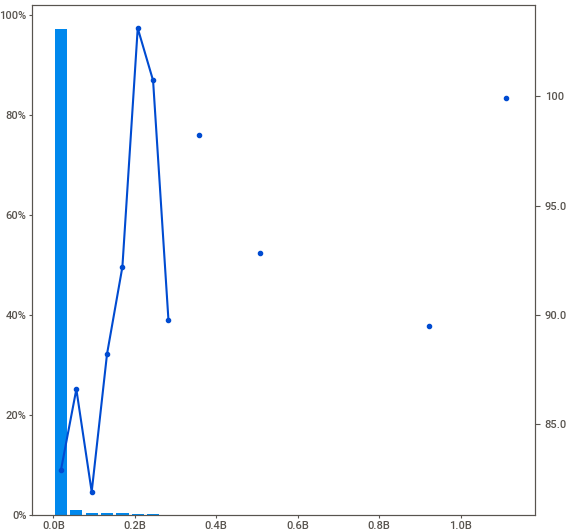
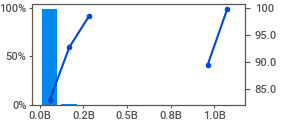
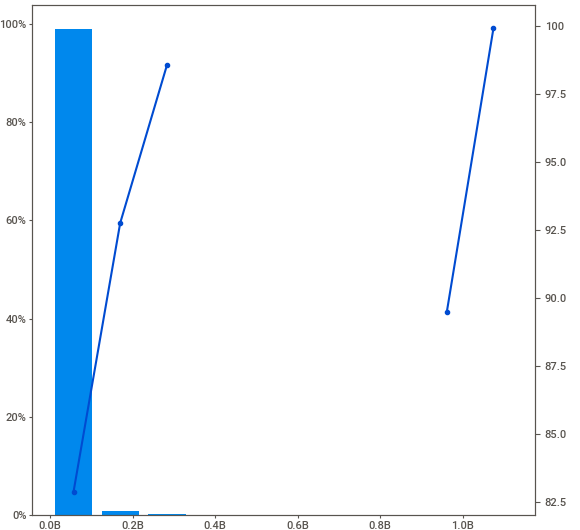
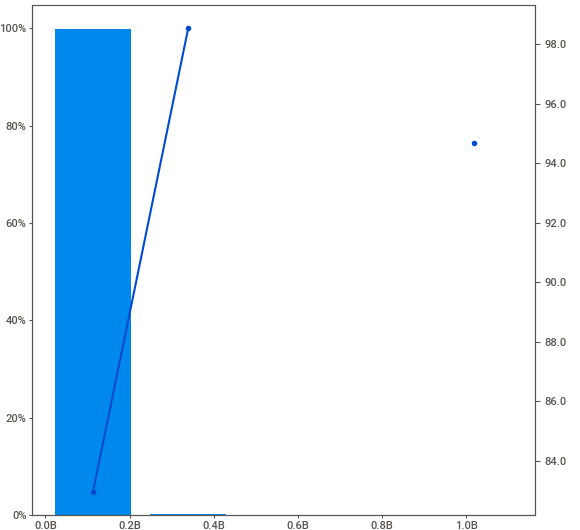
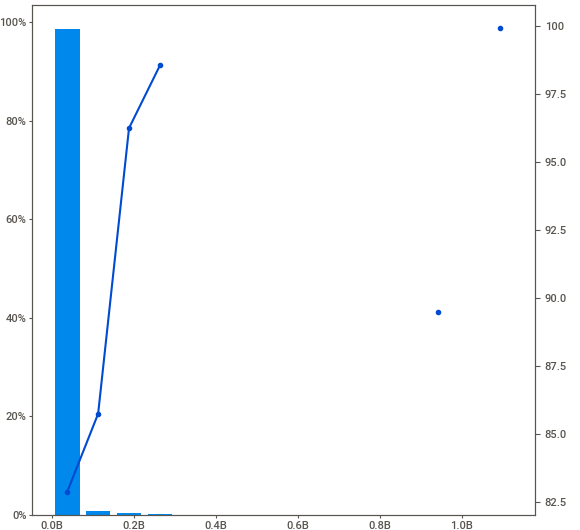
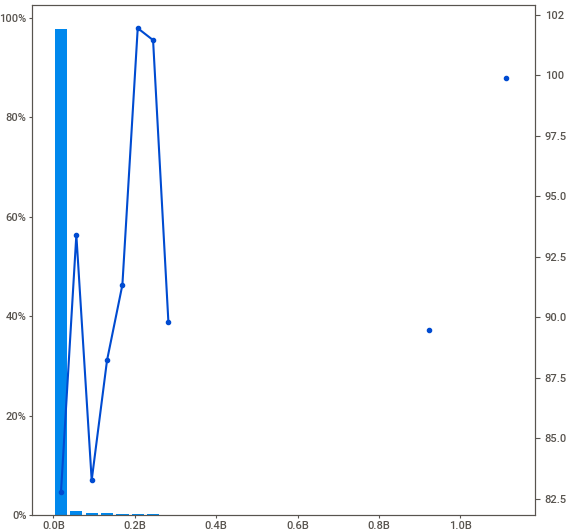
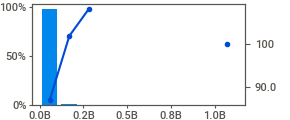
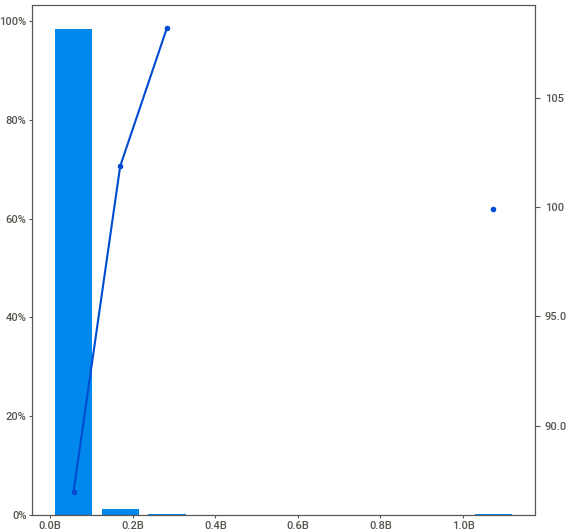
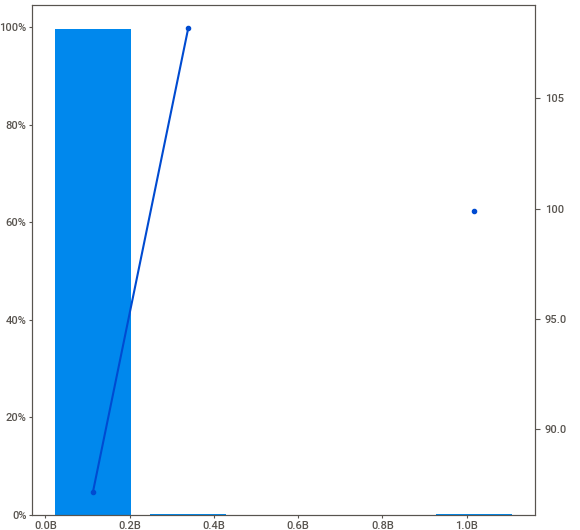
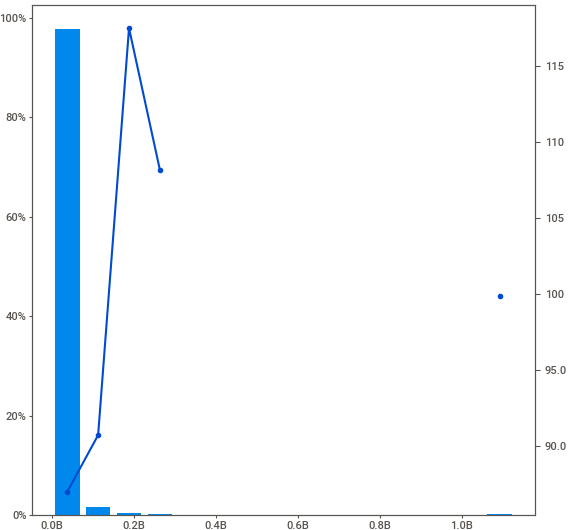
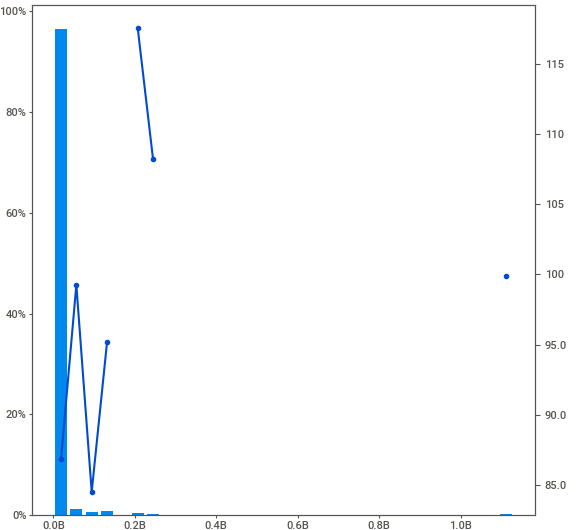
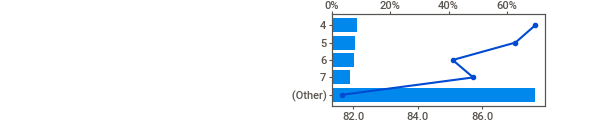
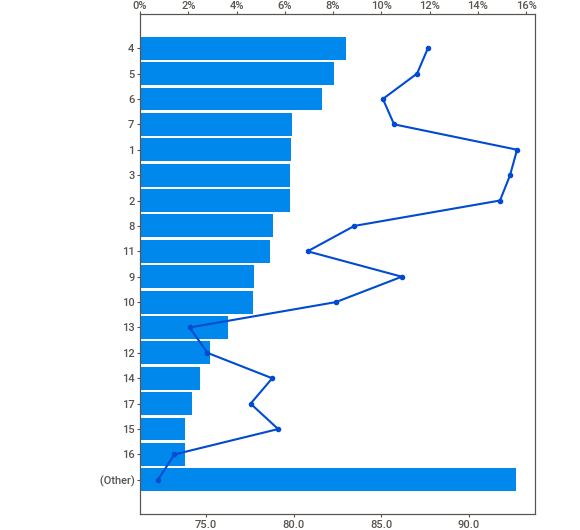
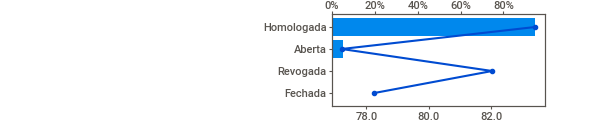
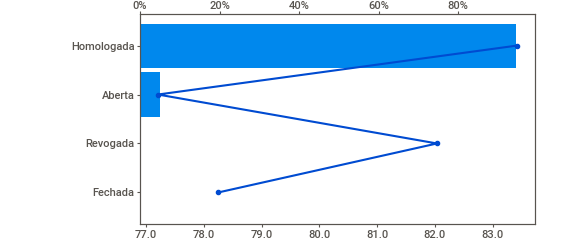
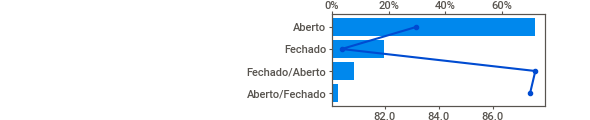
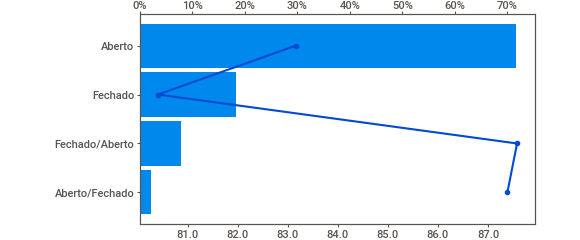
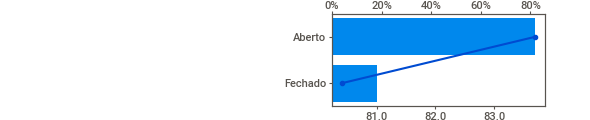
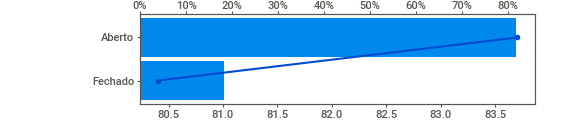
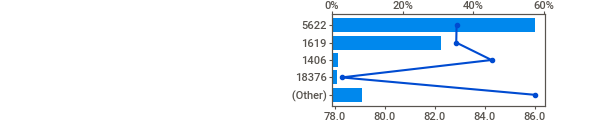
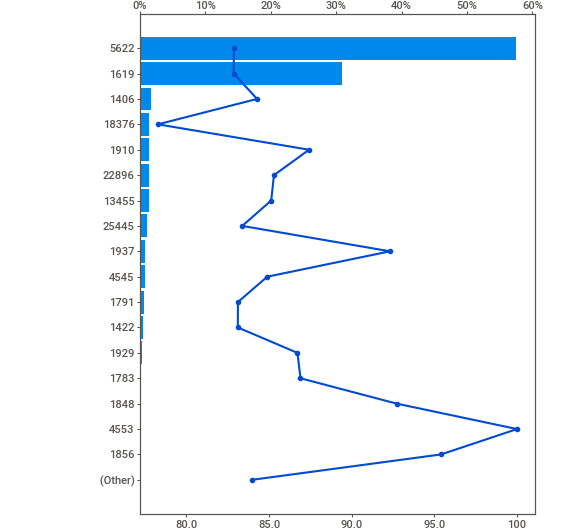
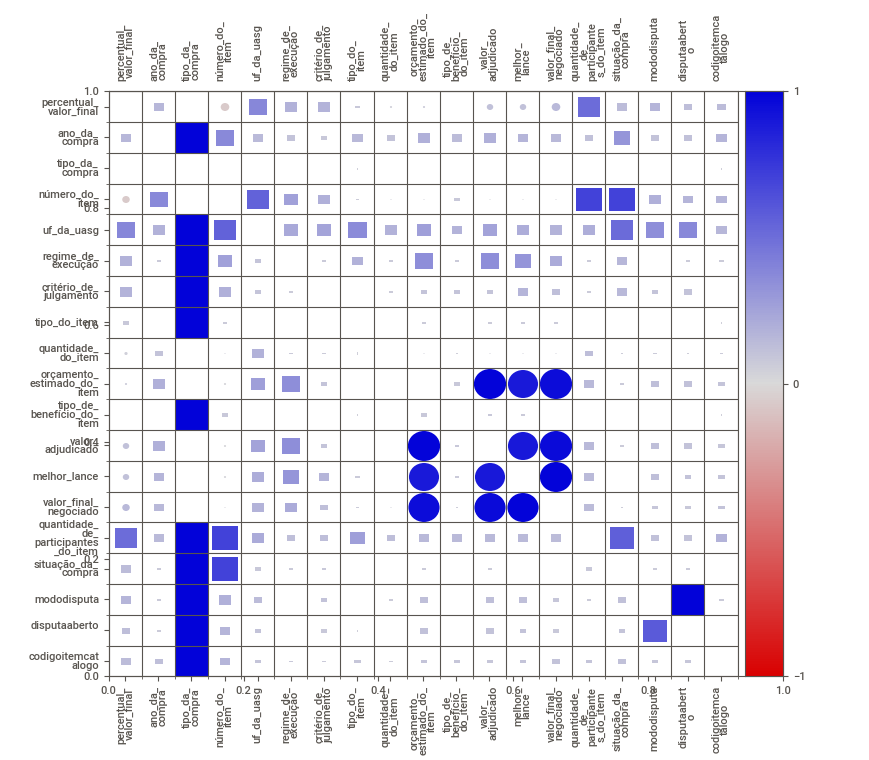
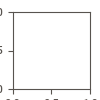

In [14]:
# SweetViz Setup
target_feature ='percentual_valor_final'
skip_features = [
    'unidade_de_fornecimento_do_item', 'link',
    'objeto_da_compra', 'grupo_do_item',
    'data_hora_da_primeira_publicação', 
    'data_hora_realização_do_certame_fim_proposta',
    'data_hora_de_homologação_da_compra',
    'data_hora_de_homologação_do_item',
    'nome_do_item', 'situação_do_item', 
    'identificação_do_fornecedor_vencedor_(adjudicado)',
    'uasg', 'compra', 'ano', 'codcompra',
    ]

feature_config = sv.FeatureConfig(skip=skip_features,
                                  force_cat=tuple([
                                      'mododisputa',
                                      'disputaaberto',
                                      ]),
                                  force_text=tuple([
                                      ]),
                                  force_num=tuple([
                                      ])
                                 ) # Possible parameters: skip, force_cat, force_num and force_text

my_report = sv.analyze(df_serpro_siasgnet, target_feat=target_feature, feat_cfg=feature_config)

# Export Report to HTML
my_report.show_html(filepath='sweetviz_report.html', 
                    open_browser=True, 
                    layout='vertical', 
                    scale=None)
                    
# Print Report to Notebook
my_report.show_notebook(w="100%",
                        h=None, 
                        scale=None, 
                        layout='vertical',
                        filepath=None)

In [15]:
# Export dataframe to CSV and Excel, all quoted
filename = 'output/extracao-rdc-serpro-siasgnet'
df_serpro_siasgnet.to_csv(f'{filename}.csv', index=False, quoting=1)
df_serpro_siasgnet.to_excel(f'{filename}.xlsx', index=False)

# Dispute Mode vs. Addendum

In [1]:
# Read the data at data/2023-09-29-extracao-rdc.ods
df_contratos = pd.read_excel('data/comprasnet_contratos.xlsx', dtype={'codcompra': str})
df_contratos_original = df_contratos.copy()
print(df_contratos.shape)
df_contratos.head()

NameError: name 'pd' is not defined

In [17]:
# Make a copy of the original df_contratos DataFrame
df_contratos = df_contratos_original.copy()

# Filter rows by c.valor_inicial != 0 and c.valor_global != 0
df_contratos = df_contratos[(df_contratos['valor_inicial'] != 0) & (df_contratos['valor_global'] != 0)]

# Compute the percentual_diferenca_valor column as the ratio of diferenca_valor to valor_inicial, multiplied by 100
df_contratos['percentual_diferenca_valor'] = df_contratos['diferenca_valor'] * 100 / df_contratos['valor_inicial']

# Remove rows where percentual_diferenca_valor is infinite
# df_contratos = df_contratos[~df_contratos['percentual_diferenca_valor'].isin([-np.inf, np.inf])]

    # Make percentual_diferenca_valor not be shown as scientific notation and sort the DataFrame by percentual_diferenca_valor descending
    # print(df_contratos.shape)
    # pd.set_option('display.float_format', lambda x: '%.2f' % x)
    # df_contratos[df_contratos['percentual_diferenca_valor'] > 1000].sort_values(by='percentual_diferenca_valor', ascending=True)

# Remove outliers where percentual_diferenca_valor is greater than or equal to 1000
df_contratos = df_contratos[df_contratos['percentual_diferenca_valor'] < 1000]

# Print information about the df_contratos DataFrame using the info() method
df_contratos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1637 entries, 0 to 1682
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   codcompra                   1637 non-null   object 
 1   aditivos                    1637 non-null   int64  
 2   vigencia_inicio             1637 non-null   object 
 3   vigencia_fim                1636 non-null   object 
 4   anos                        1636 non-null   float64
 5   valor_inicial               1637 non-null   float64
 6   valor_global                1637 non-null   float64
 7   diferenca_valor             1637 non-null   float64
 8   percentual_diferenca_valor  1637 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 127.9+ KB


### SweetViz

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



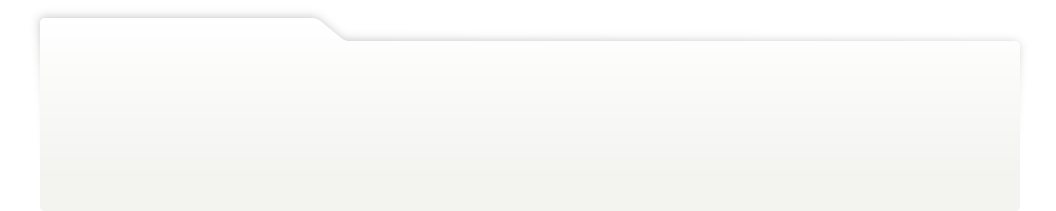
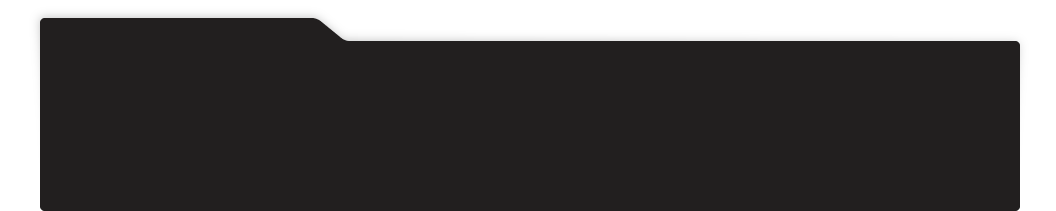
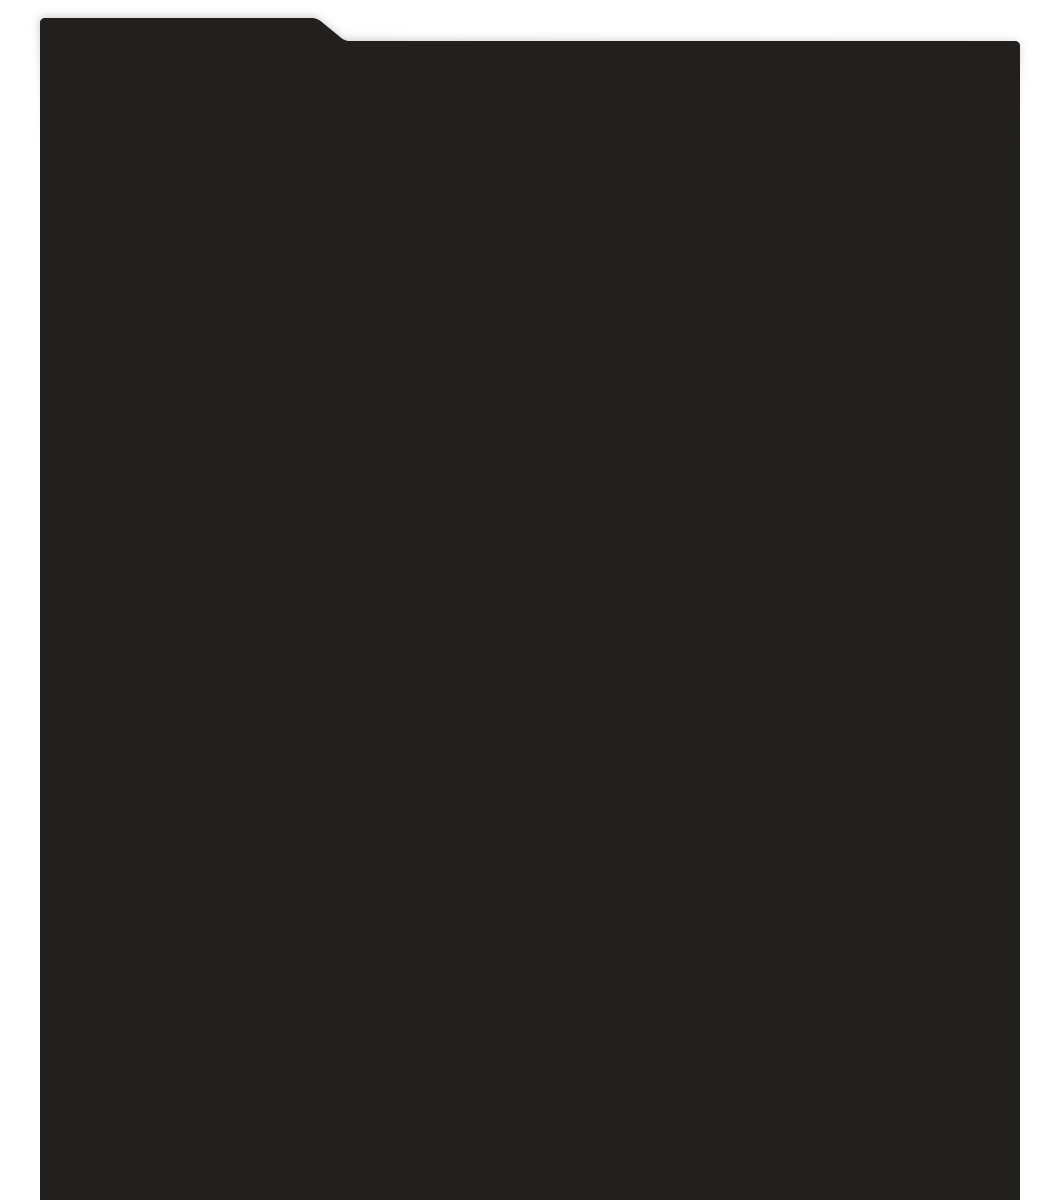
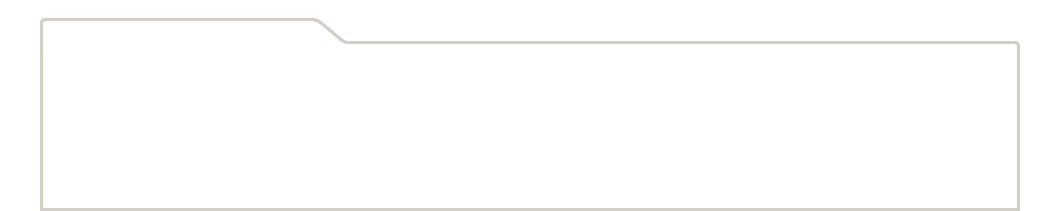
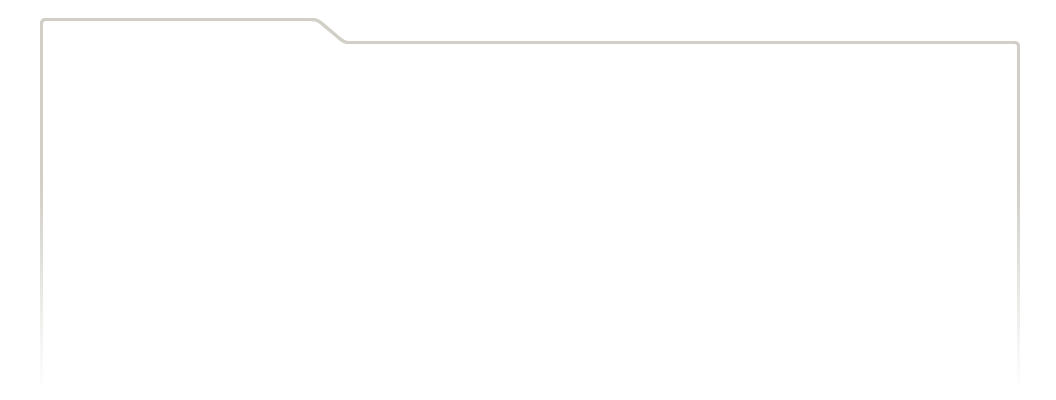
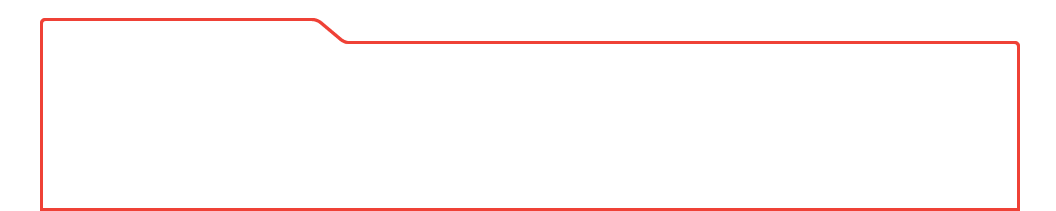
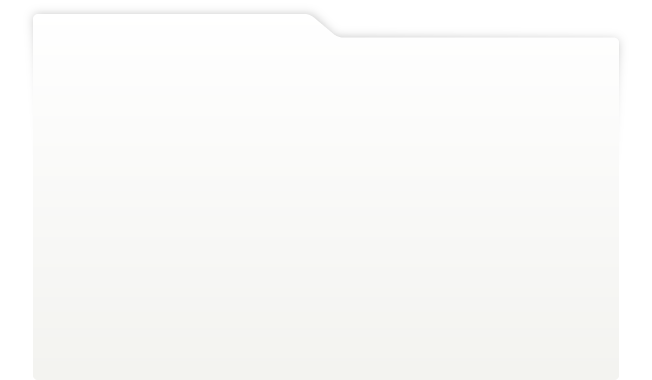
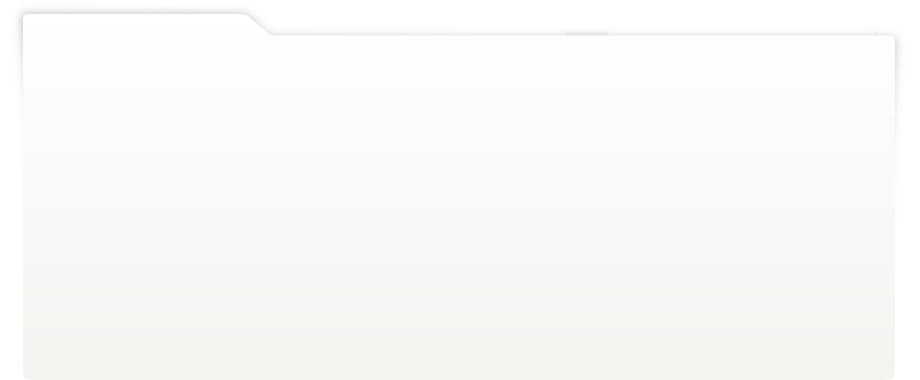
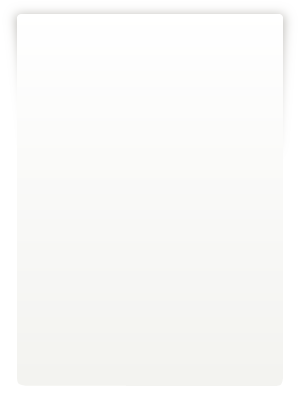
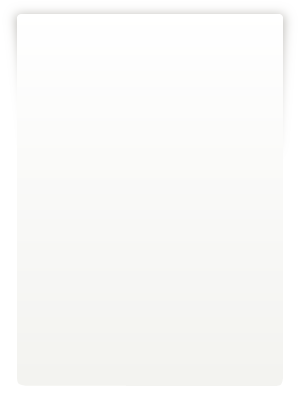
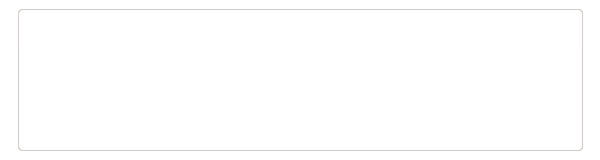
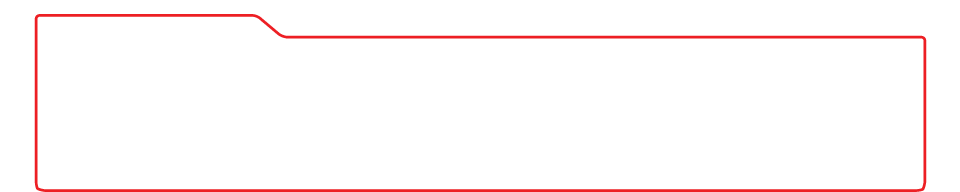
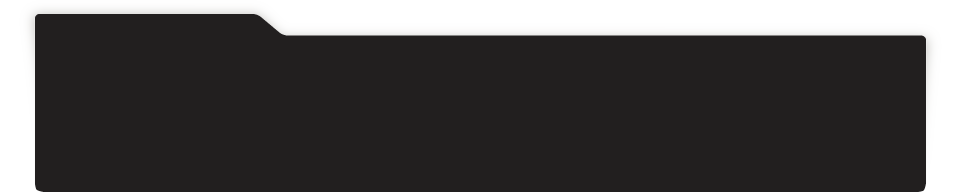
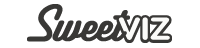
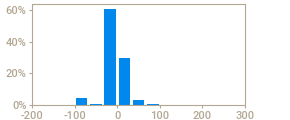
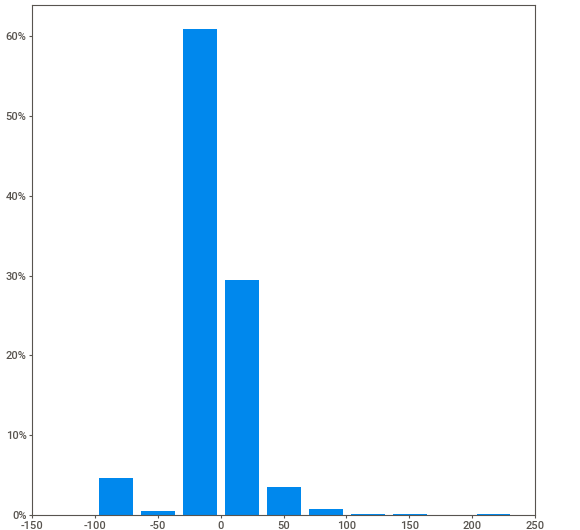
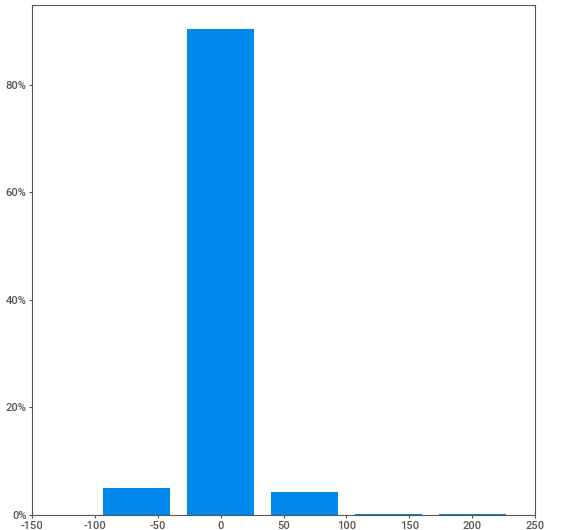
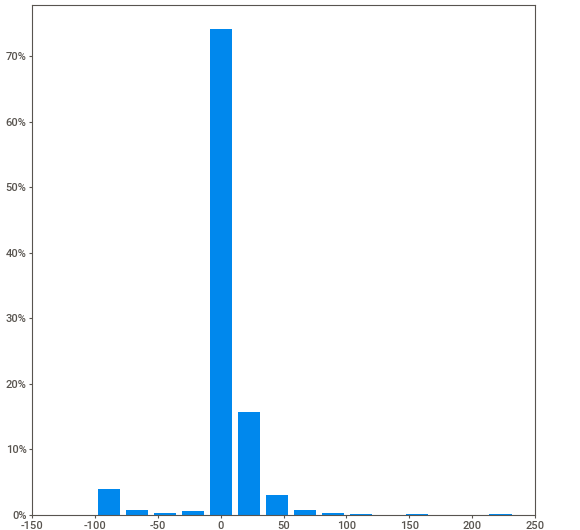
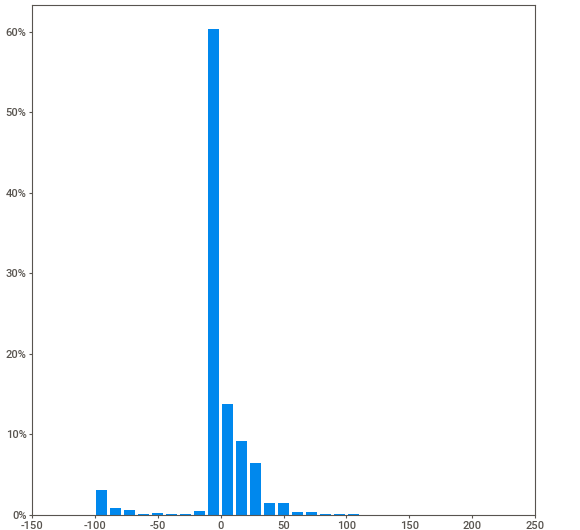
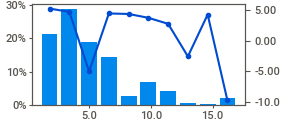
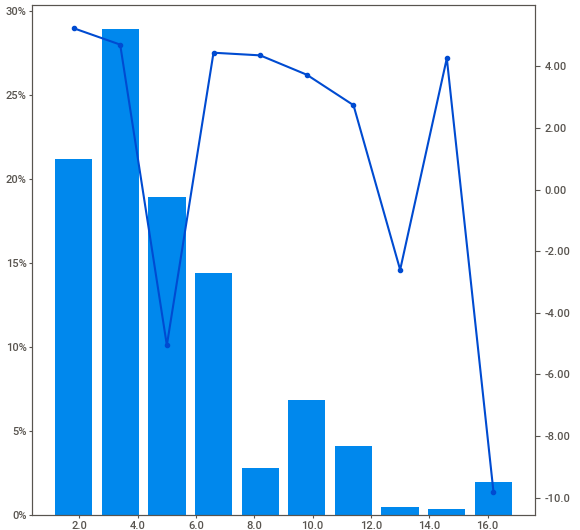
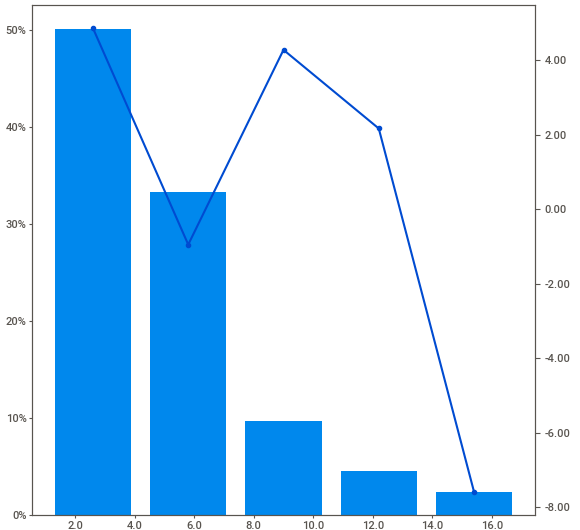
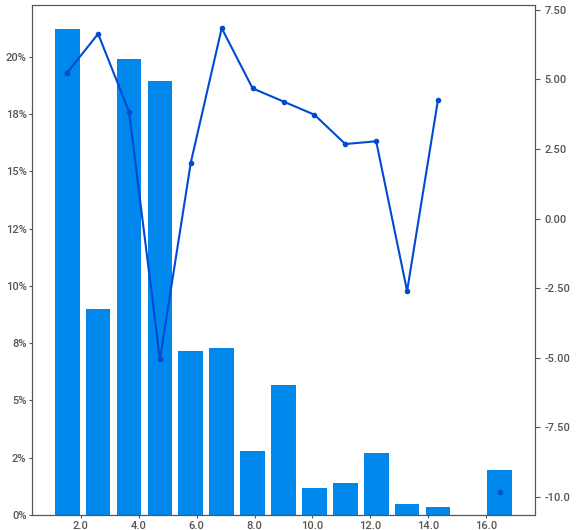
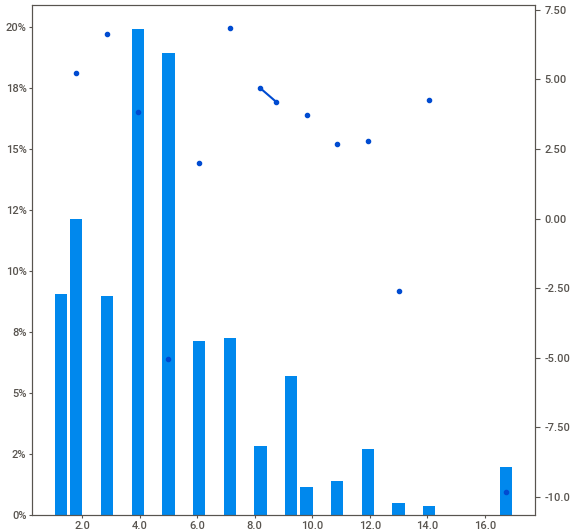
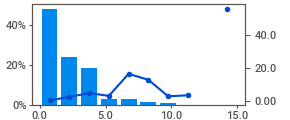
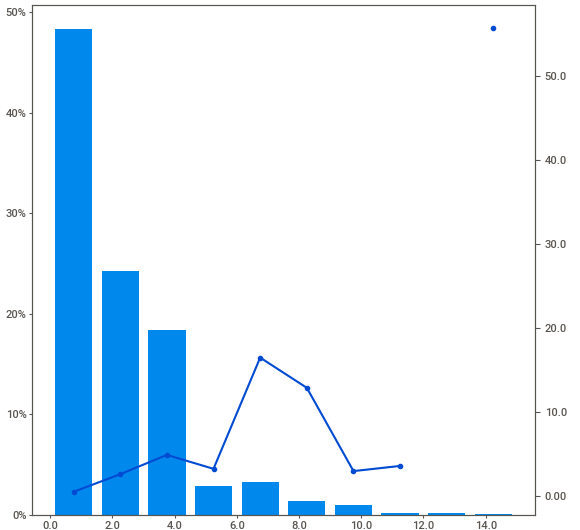
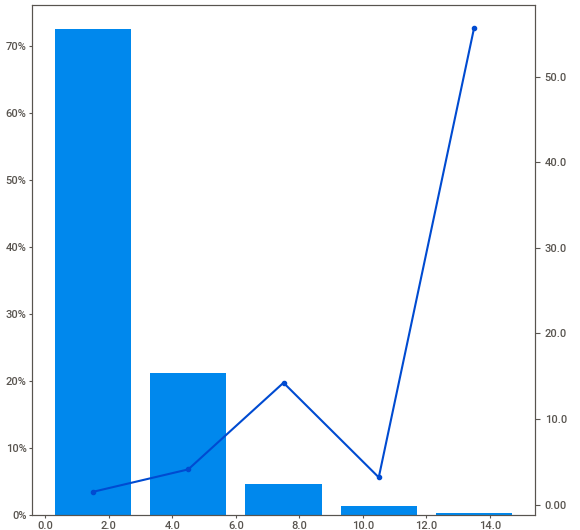
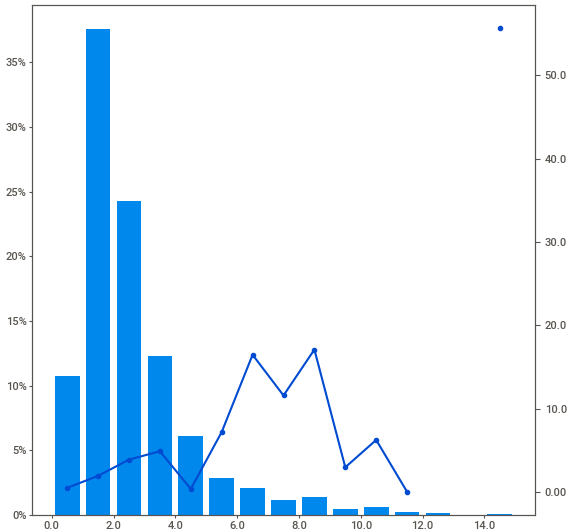
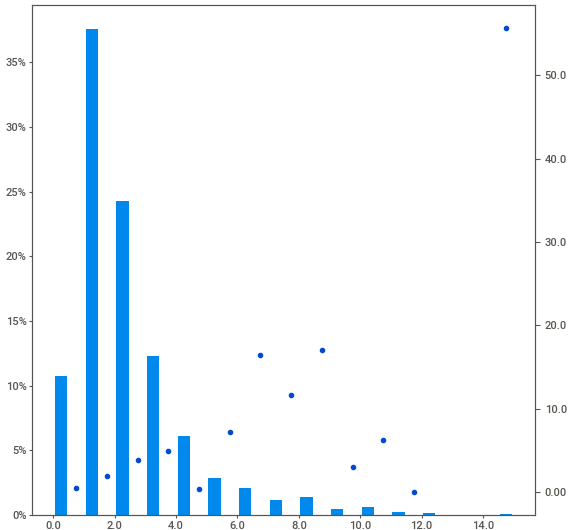
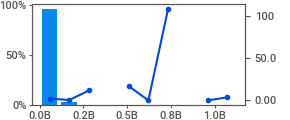
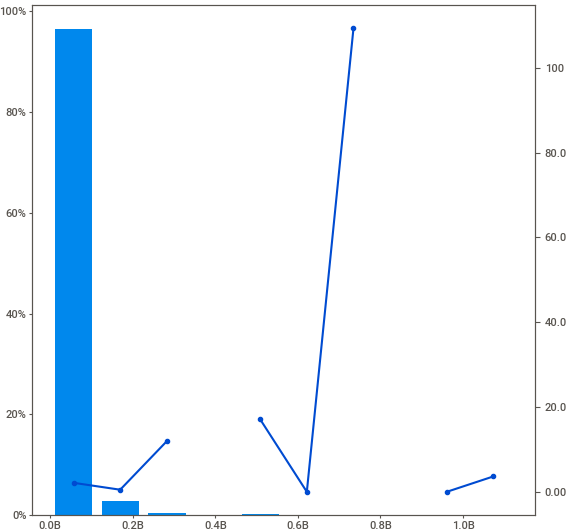
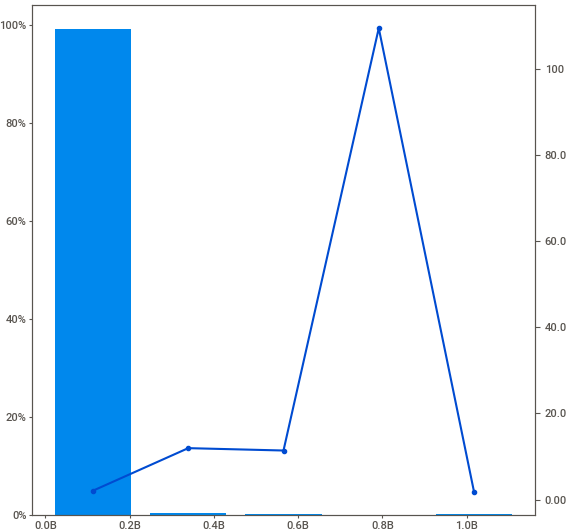
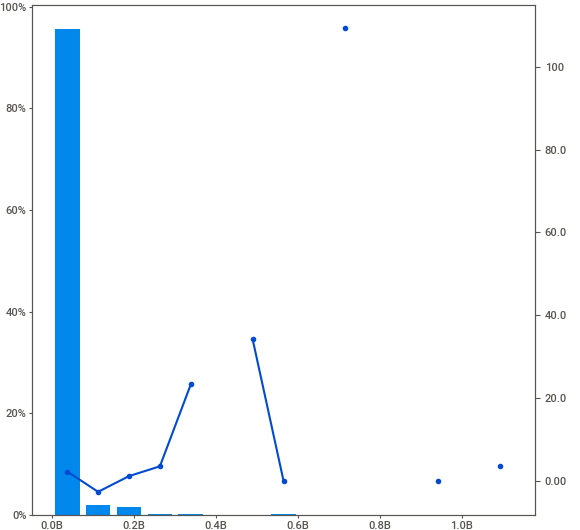
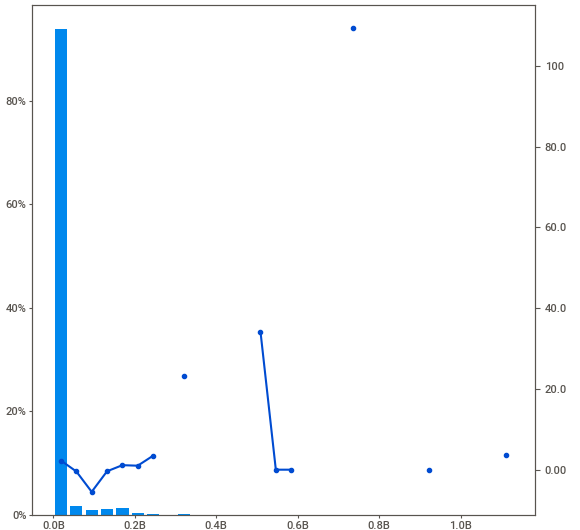
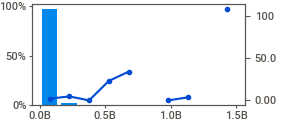
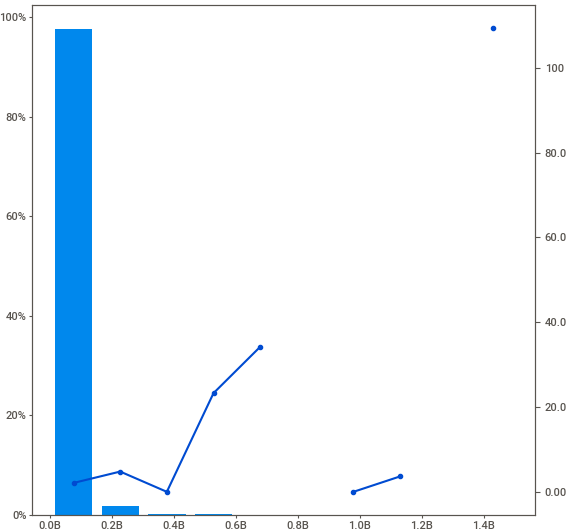
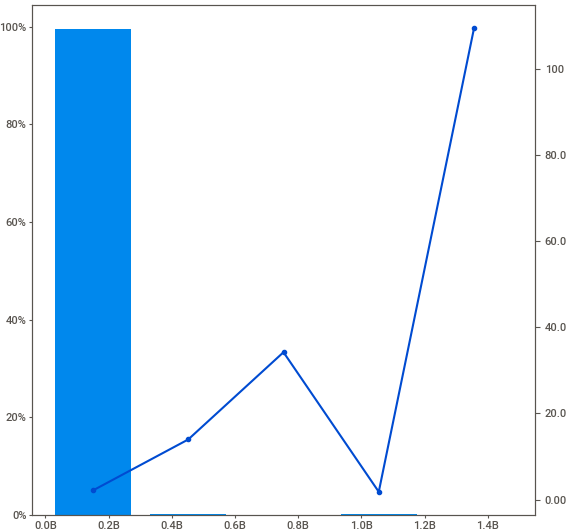
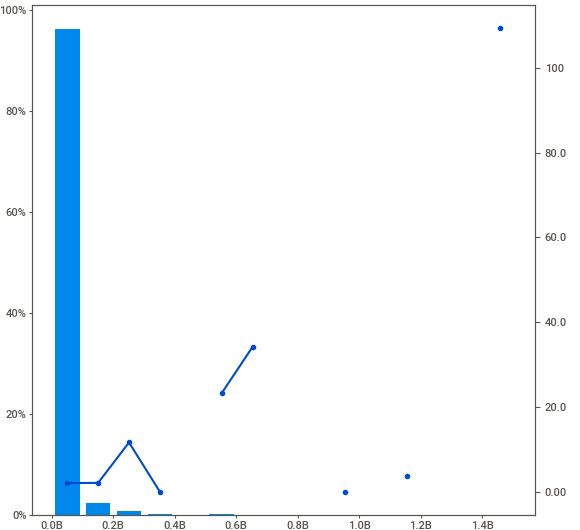
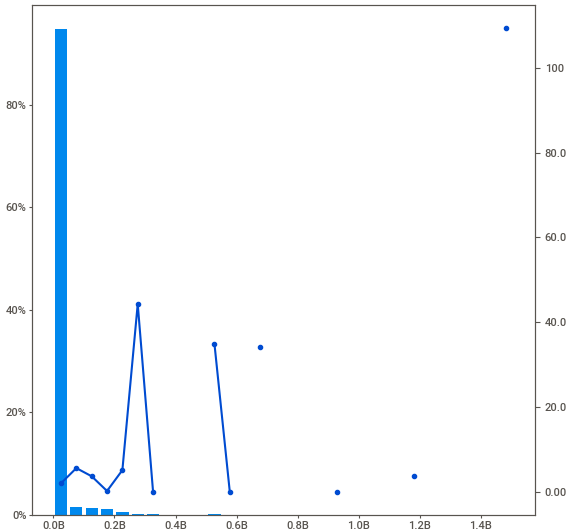
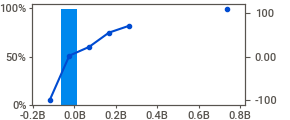
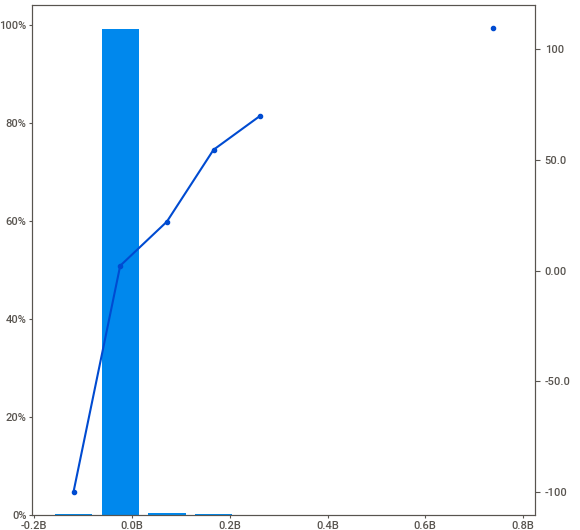
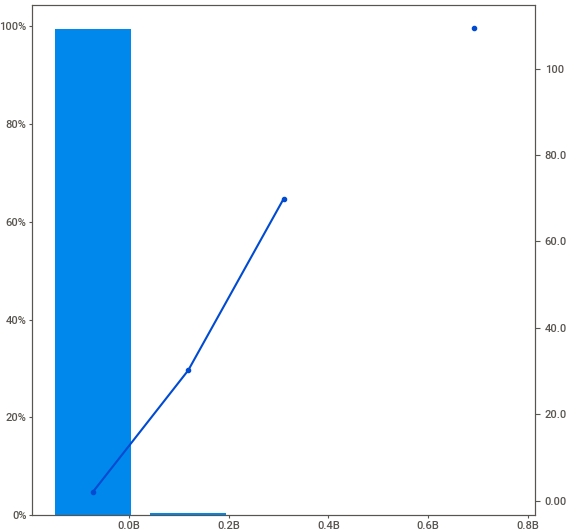
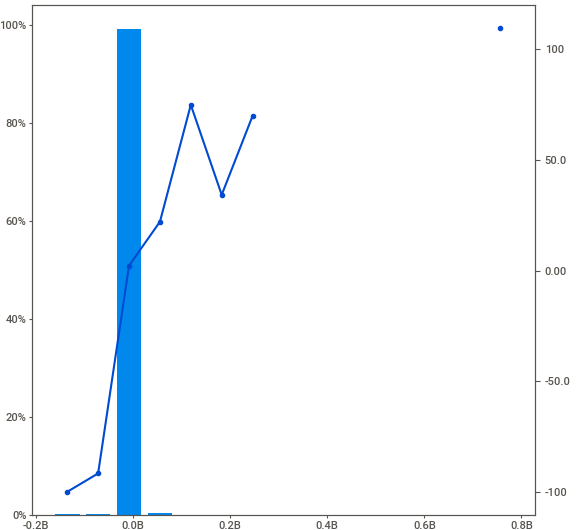
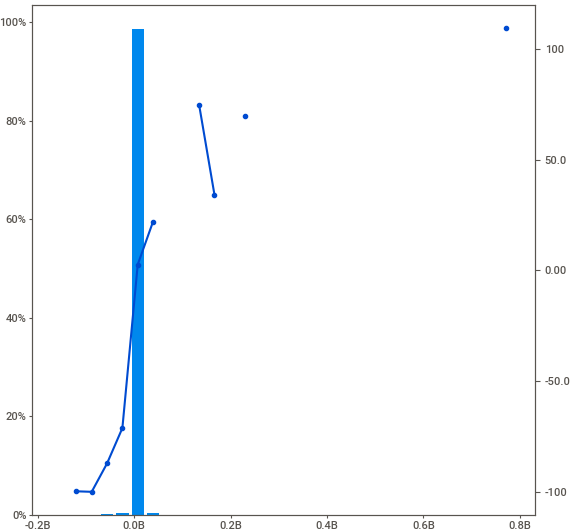
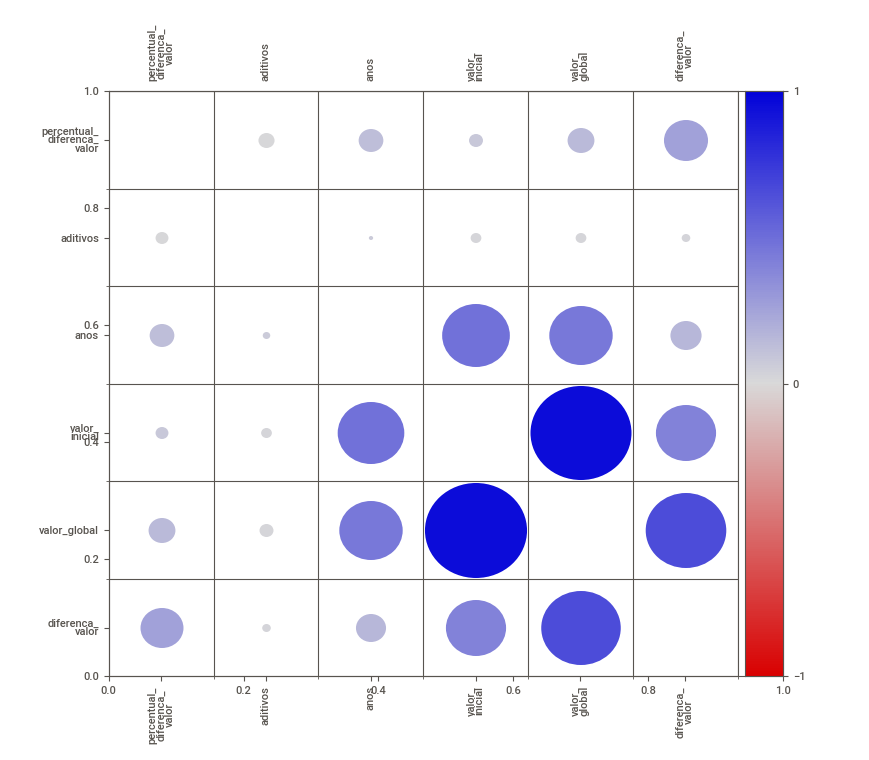
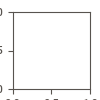

In [18]:
df_sweetviz = df_contratos.copy()

# Replace NaN values with 0
df_sweetviz.fillna(0, inplace=True)

# SweetViz Setup
target_feature ='percentual_diferenca_valor'
skip_features = ['vigencia_fim']

feature_config = sv.FeatureConfig(skip=skip_features,
                                  force_cat=tuple([
                                      ]),
                                  force_text=tuple([
                                      ]),
                                  force_num=tuple([
                                      ])
                                 ) # Possible parameters: skip, force_cat, force_num and force_text

my_report = sv.analyze(df_sweetviz, target_feat=target_feature, feat_cfg=feature_config)

# Export Report to HTML
# my_report.show_html(filepath='sweetviz_report_contratos.html', 
#                     open_browser=True, 
#                     layout='vertical', 
#                     scale=None)
                    
# Print Report to Notebook
my_report.show_notebook(w="100%",
                        h=None, 
                        scale=None, 
                        layout='vertical',
                        )


## Join DataFrames (df_serpro_siasgnet, df_contratos)

In [19]:
# Set pandas to show all columns
pd.set_option('display.max_columns', None)

# Concatenate df_serpro with df_siasgnet.mododisputa using codcompra as key with distinct values of df_serpro_siasgnet['codcompra']
df_aditivos = pd.merge(
    df_serpro_siasgnet[['codcompra', 'mododisputa', 'disputaaberto']].drop_duplicates(),
    df_contratos, 
    how='inner', 
    on='codcompra',
    )

print(df_aditivos.shape)
df_aditivos

(507, 11)


,codcompra,mododisputa,disputaaberto,aditivos,vigencia_inicio,vigencia_fim,anos,valor_inicial,valor_global,diferenca_valor,percentual_diferenca_valor
0,15441999000052013,Aberto,Aberto,17,2014-02-05,2021-03-31,7.0,4400000.00,4400000.00,0.00,0.000000
1,15809299000042014,Aberto,Aberto,1,2016-04-19,2021-10-11,5.0,6468407.43,6468407.43,0.00,0.000000
2,15813699000022014,Fechado/Aberto,Aberto,7,2015-02-12,2022-03-30,7.0,27586169.56,27586169.56,0.00,0.000000
3,39300999002742014,Aberto,Aberto,3,2017-06-01,2024-05-18,7.0,24200000.00,11427702.37,-12772297.63,-52.778089
4,39301399002252014,Aberto,Aberto,4,2014-07-04,2023-05-12,9.0,15366612.90,15366612.90,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
502,39301999003662022,Aberto,Aberto,3,2022-12-23,2025-06-09,3.0,4945237.83,5292393.44,347155.61,7.019998
503,39302299003072022,Aberto,Aberto,3,2022-09-27,2025-06-27,3.0,31950000.00,31950000.00,0.00,0.000000
504,39303099001092022,Aberto,Aberto,4,2022-09-01,2023-08-26,1.0,6573141.18,6573141.18,0.00,0.000000
505,39500199000012022,Fechado,Fechado,2,2022-06-27,2024-06-27,2.0,5583498.88,5583498.88,0.00,0.000000


In [20]:
# Export dataframe to CSV and Excel, all quoted
filename = 'output/resultado-rdc-aditivos'
df_aditivos.to_csv(f'{filename}.csv', index=False, quoting=1)
df_aditivos.to_excel(f'{filename}.xlsx', index=False)

### Média de valores acrescidos em termos aditivos por modo de disputa

mododisputa
Aberto            1.63 (378)
Aberto/Fechado       0.0 (7)
Fechado             9.6 (86)
Fechado/Aberto     0.38 (36)
Name: percentual_diferenca_valor, dtype: object
disputaaberto
Aberto     1.49 (421)
Fechado      9.6 (86)
Name: percentual_diferenca_valor, dtype: object


<Axes: ylabel='Frequency'>

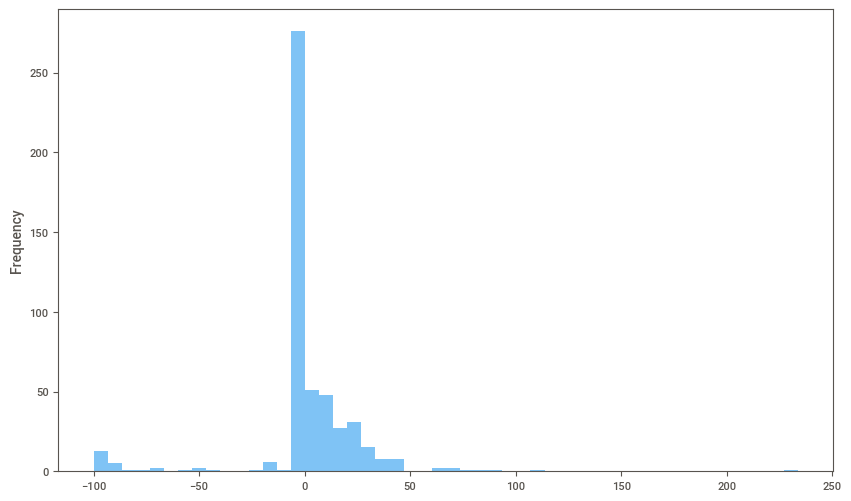

In [21]:
# Eliminate outliers from percentual_valor_final
df_plot = df_aditivos.copy()

# Calculate the mean of percentual_valor_final by mododisputa rounded to 2 decimal places and the counts
print((df_plot.groupby('mododisputa')['percentual_diferenca_valor'].mean().round(2)).astype(str) + 
      ' (' + df_plot.groupby('mododisputa')['percentual_diferenca_valor'].count().astype(str) + ')')
print((df_plot.groupby('disputaaberto')['percentual_diferenca_valor'].mean().round(2)).astype(str) + 
      ' (' + df_plot.groupby('disputaaberto')['percentual_diferenca_valor'].count().astype(str) + ')')

# Calculate and plot the distribution of percentual_valor_final
df_plot['percentual_diferenca_valor'].plot.hist(bins=50, figsize=(10,6), alpha=0.5)

In [25]:
# Replicate the print output to a dataframe
df_mododisputa_contratos_consolidado_valores = df_aditivos.groupby('mododisputa')['percentual_diferenca_valor'].agg(['mean', 'count']).round(2).reset_index().rename(columns={'mododisputa': 'Modo de Disputa', 'mean': 'Média', 'count': 'Quantidade'})
df_disputaaberto_contratos_consolidado_valores = df_aditivos.groupby('disputaaberto')['percentual_diferenca_valor'].agg(['mean', 'count']).round(2).reset_index().rename(columns={'disputaaberto': 'Modo de Disputa Agregado', 'mean': 'Média', 'count': 'Quantidade'})
print(df_mododisputa_contratos_consolidado_valores)
print(df_disputaaberto_contratos_consolidado_valores)

  Modo de Disputa  Média  Quantidade
0          Aberto   1.63         378
1  Aberto/Fechado   0.00           7
2         Fechado   9.60          86
3  Fechado/Aberto   0.38          36
  Modo de Disputa Agregado  Média  Quantidade
0                   Aberto   1.49         421
1                  Fechado   9.60          86


## Média de aditivos por modo de disputa

mododisputa
Aberto            5.61 (378)
Aberto/Fechado      2.14 (7)
Fechado             5.4 (86)
Fechado/Aberto     4.17 (36)
Name: aditivos, dtype: object
disputaaberto
Aberto     5.43 (421)
Fechado      5.4 (86)
Name: aditivos, dtype: object


<Axes: ylabel='Frequency'>

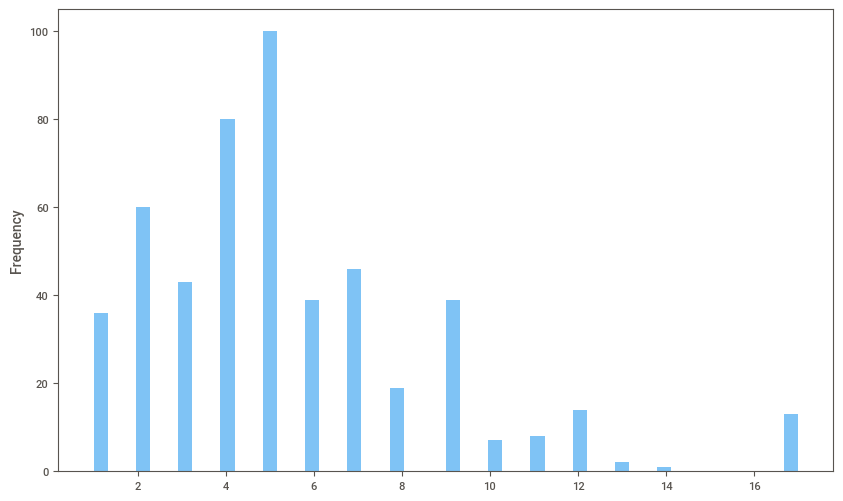

In [23]:
df_plot = df_aditivos.copy()

# Calculate the mean of percentual_valor_final by mododisputa rounded to 2 decimal places and the counts
print((df_plot.groupby('mododisputa')['aditivos'].mean().round(2)).astype(str) + 
      ' (' + df_plot.groupby('mododisputa')['aditivos'].count().astype(str) + ')')
print((df_plot.groupby('disputaaberto')['aditivos'].mean().round(2)).astype(str) + 
      ' (' + df_plot.groupby('disputaaberto')['aditivos'].count().astype(str) + ')')

# Calculate and plot the distribution of percentual_valor_final
df_plot['aditivos'].plot.hist(bins=50, figsize=(10,6), alpha=0.5)

In [26]:
# Replicate the print output to a dataframe
df_mododisputa_contratos_consolidado_aditivos = df_aditivos.groupby('mododisputa')['aditivos'].agg(['mean', 'count']).round(2).reset_index().rename(columns={'mododisputa': 'Modo de Disputa', 'mean': 'Média', 'count': 'Quantidade'})
df_disputaaberto_contratos_consolidado_aditivos = df_aditivos.groupby('disputaaberto')['aditivos'].agg(['mean', 'count']).round(2).reset_index().rename(columns={'disputaaberto': 'Modo de Disputa Agregado', 'mean': 'Média', 'count': 'Quantidade'})
print(df_mododisputa_contratos_consolidado_aditivos)
print('')
print(df_disputaaberto_contratos_consolidado_aditivos)

  Modo de Disputa  Média  Quantidade
0          Aberto   5.61         378
1  Aberto/Fechado   2.14           7
2         Fechado   5.40          86
3  Fechado/Aberto   4.17          36

  Modo de Disputa Agregado  Média  Quantidade
0                   Aberto   5.43         421
1                  Fechado   5.40          86
